# NBD Lab Project

## Install all the needed pip dependencies

In [1]:
%%capture
!pip install -r requirements.txt

## Importing the needed libraries

In [2]:
import polars as pl
import pandas as pd
from pathlib import Path

import requests
import re

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from ip2geotools.databases.noncommercial import DbIpCity
import folium
from folium.plugins import MarkerCluster

import ipaddress

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, confusion_matrix, auc

from sklearn.pipeline import Pipeline

from scipy.stats import uniform, randint

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

import math
from collections import Counter

## Setting the needed paths

In [3]:
current_path = Path('.')
data_path = current_path/'data'
pcap_path = data_path/'pcap.parquet'

## Section A

### 1) Extract general info from your trace using capinfos

In [4]:
!python src/capinfos.py

Getting capture infos about data/data_00000_20190410070000.pcap

Number of packets  in the capture:
-----------------------------------------------------------------
File name:           data/data_00000_20190410070000.pcap
Packet size limit:   inferred: 34 bytes - 96 bytes (range)
Number of packets:   5,000 k


The average data reate in bits/sec:
-----------------------------------------------------------------
File name:           data/data_00000_20190410070000.pcap
Packet size limit:   inferred: 34 bytes - 96 bytes (range)
Data bit rate:       2,729 Mbps


The average packet size:
-----------------------------------------------------------------
File name:           data/data_00000_20190410070000.pcap
Packet size limit:   inferred: 34 bytes - 96 bytes (range)
Average packet size: 1198.22 bytes


General all infos:
-----------------------------------------------------------------
File name:           data/data_00000_20190410070000.pcap
File type:           Wireshark/... - pcapng
File 

In [5]:
display(pl.read_csv(data_path/'capinfos.csv'))

File name,File type,File encapsulation,File time precision,Packet size limit,Packet size limit min (inferred),Packet size limit max (inferred),Number of packets,File size (bytes),Data size (bytes),Capture duration (seconds),Start time,End time,Data byte rate (bytes/sec),Data bit rate (bits/sec),Average packet size (bytes),Average packet rate (packets/sec),SHA256,RIPEMD160,SHA1,Strict time order,Capture hardware,Capture oper-sys,Capture application,Capture comment
str,str,str,str,str,i64,i64,i64,i64,i64,f64,str,str,f64,f64,f64,f64,str,str,str,bool,str,str,str,str
"""data/data_0000…","""pcapng""","""ether""","""microseconds""","""(not set)""",34,96,5000000,490189160,5991123026,17.55763,"""2019-04-10 07:…","""2019-04-10 07:…",3.4123e8,2.7298e9,1198.22,284776.48,"""17c90cad2fbbde…","""fc1047598207df…","""968263edd2013c…",false,"""""","""""","""Editcap (Wires…",""""""


### 2) Time Evaluation between Sequential and Parallel reading

For solving this question we have written a specific script `extract_packets.py`, which can be found in the `src/` folder.

Because we have used the [joblib.Parallel()](https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html) framework our script is able to perform both sequential and parallel reading.

#### Sequential Reading

To perform a sequential reading, in a terminal from the root folder run:

```bash
python src/extract_packets.py -j 1
```

The `-j` argument set to 1 will tell `Parallel` to use only 1 worker, resulting in a sequential run.

#### Parallel Reading

To use all the available workes just run in a terminal from the root folder.

```bash
python src/extract_packets.py
```

If you want to use a specific number of workers just set `-j` accordingly (e.g. `-j 4` to use 4 workers).

### Results on the entire pcap (5M of packets)

|Type of Reading| Time (seconds)|Time (minutes)|
|-------------------|------|-------------|
|Sequential Reading|12410.356|206.84|
|Parallel Reading|11692.876|194.88|

> These results were obtained using a *12th Gen Intel i5-1235U (12) @ 4.400GHz* CPU and using all the available workers (12) for Parallel reading.

### Read the parquet file and get the 1M slice

In [6]:
n = 1_000_000
df = pl.read_parquet(pcap_path).slice(0, n)

In [7]:
display(df)

dsfield_dscp,hdr_len,dsfield,dsfield_ecn,len,proto,flags_df,flags_mf,flags_rb,frag_offset,ttl,src,dst,srcport,dstport,sniff_timestamp
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,f64
0,20,0,0,52,6,0,0,0,0,54,"""180.213.208.20…","""203.122.136.47…",53480,80,1.5549e9
0,20,0,0,52,6,0,0,0,0,54,"""180.213.208.20…","""203.122.136.47…",53480,80,1.5549e9
0,20,0,0,141,17,0,0,0,0,58,"""150.57.190.76""","""155.70.48.196""",50821,27023,1.5549e9
0,20,0,0,1420,6,1,0,0,0,60,"""202.7.174.242""","""172.201.31.90""",55816,443,1.5549e9
0,20,0,0,95,17,1,0,0,0,57,"""23.53.35.140""","""131.137.126.25…",53,48350,1.5549e9
0,20,0,0,1420,6,1,0,0,0,56,"""150.57.136.251…","""221.244.225.17…",80,64918,1.5549e9
0,20,0,0,1420,6,1,0,0,0,56,"""150.57.136.251…","""221.244.225.17…",80,64918,1.5549e9
0,20,0,0,1420,6,1,0,0,0,56,"""150.57.136.251…","""221.244.225.17…",80,64918,1.5549e9
0,20,0,0,52,6,1,0,0,0,60,"""202.7.174.242""","""192.226.35.111…",61188,443,1.5549e9


### 3) Extract the IP which generates the highest amount of sender traffic, evaluate the bit rate (0.1 sec) for the 6 IP addresses mostly used as endpoint

#### Auxiliary functions:

In [8]:
def bit_rate(data: pl.DataFrame,
             step_sec: float = 1.) -> list[float]:
    """This function return the bit rate curve (as an array) from a dataframe specific of an IP.

    Args:
        - data (pl.DataFrame): The IP specific polars.DataFrame.
        - step_sec (float): The time step to consider for the evaluation.

    Returns:
        - values (list[float]): The list of bit rate values needed for the curve.
    """
    data = data.sort("sniff_timestamp")
    data = data.with_columns(sniff_timestamp=pl.col("sniff_timestamp")-pl.col("sniff_timestamp").min())
    start = data.get_column("sniff_timestamp").item(0)
    end = data.get_column("sniff_timestamp").item(-1)

    values = []

    for step in np.arange(start, end+step_sec, step_sec):
        values.append(data
                      .lazy()
                      .filter((pl.col("sniff_timestamp") >= step)&(pl.col("sniff_timestamp") < step+step_sec))
                      .with_columns(bit=pl.col("len")*8)
                      .collect()
                      .get_column("bit")
                      .sum() / step_sec)

    return values


def get_ip_info(ip: str) -> tuple[tuple[str, str], str]:
    """Define a function that takes an IP address as input and returns the localization
    and ISP/organization information.

    Args:
        - ip (str): The string version of the ip to check.

    Returns:
        - tuple[tuple[str, str], str] : A tuple containing as first vaule the information about
                                        the localization of the IP (city, country) and as second
                                        the name of the organization.
    """
    url = f"https://ipinfo.io/{ip}/json/"
    response = requests.get(url)
    data = response.json()

    localization = data["city"], data["country"]
    isps= data.get("org", "Unknown")
    return localization, isps

#### Get the IP which generates the highest traffic:

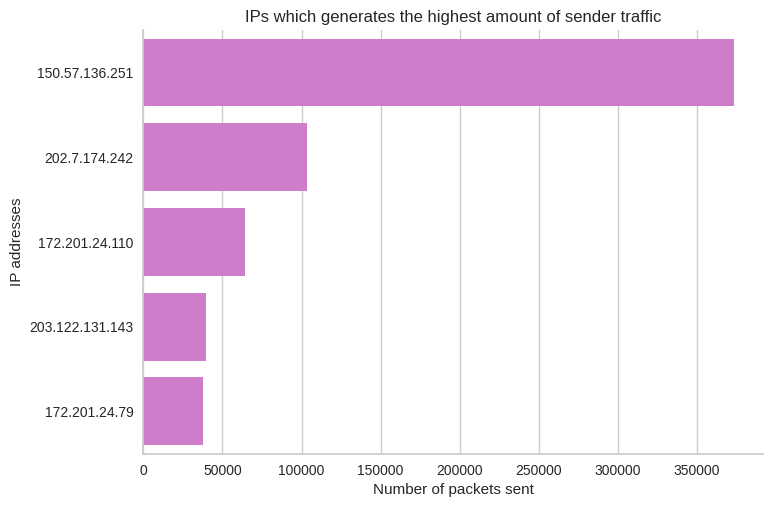

In [9]:
highest_traffic_ips = (df
                      .lazy()
                      .groupby(by='src')
                      .count()
                      .sort(by='count', descending=True)).collect()

plot = sns.barplot(highest_traffic_ips.head(5).to_pandas(),
                   y="src",
                   x="count",
                   orient="h",
                   color="orchid")

plot.set(title="IPs which generates the highest amount of sender traffic",
         xlabel='Number of packets sent',
         ylabel="IP addresses")

sns.despine()
plt.savefig("ip_highest_traffic.svg", format='svg', bbox_inches = "tight")
plt.show()
ip_highest_traffic = highest_traffic_ips.get_column("src").item(0)

#### Get the 6 IP addresses mostly used as endpoint:

In [10]:
most_used_endpoints = (df
                       .lazy()
                       .filter(pl.col("src")==ip_highest_traffic)
                       .groupby(by="dst")
                       .agg(pl.col("len").sum())
                       .sort(by="len", descending=True)
                       .select(pl.col("dst"))
                       .head(6)).collect()

print("The 6 IP addresses mostly used as endpoint:")
with pl.Config(fmt_str_lengths=20):
    display(most_used_endpoints)

The 6 IP addresses mostly used as endpoint:


dst
str
"""222.127.201.52"""
"""66.132.46.70"""
"""115.181.56.11"""
"""221.246.5.50"""
"""39.18.205.141"""
"""221.244.225.179"""


#### Display the bit rate curves:

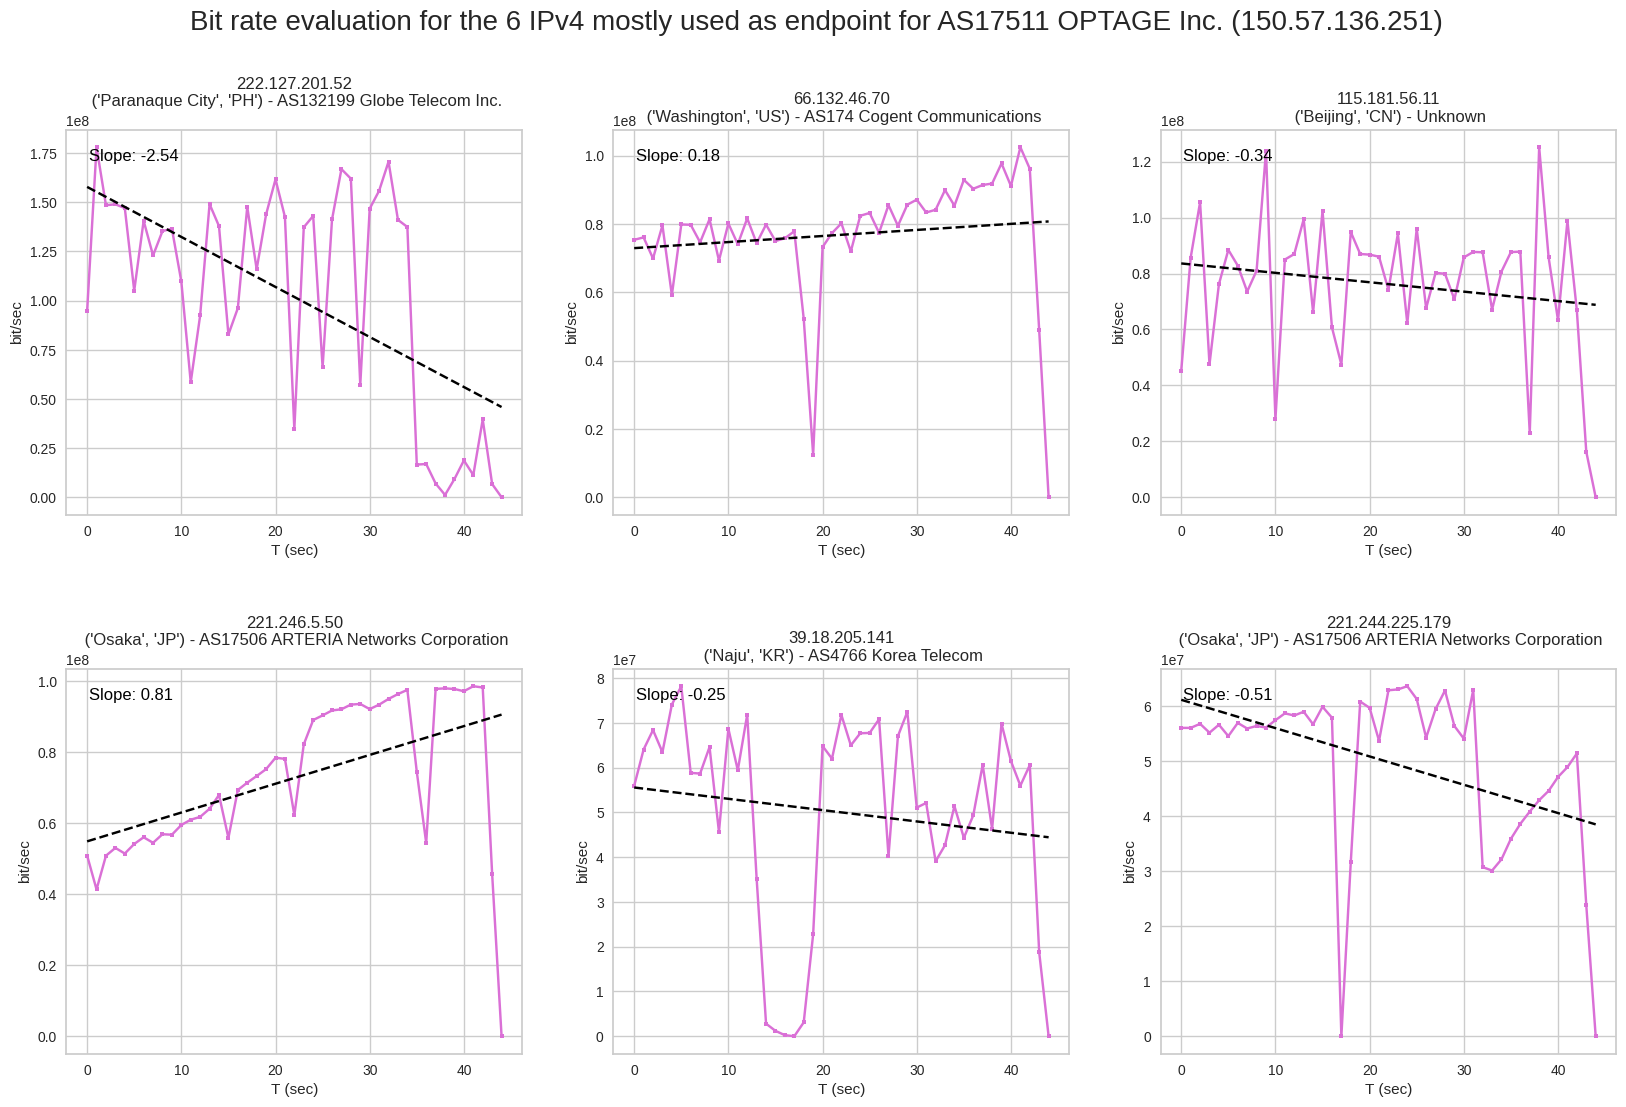

In [11]:
rows, _ = most_used_endpoints.shape
rowlength = rows//2
fig, axs = plt.subplots(figsize=(20, 12), nrows=2, ncols=rowlength, gridspec_kw=dict(hspace=0.4))

temp = df.filter(pl.col("dst").is_in(most_used_endpoints.get_column("dst"))).groupby(by="dst")

for ip, ax in zip(most_used_endpoints.get_column("dst"), axs.flatten()):

    bit_rate_data = bit_rate(df.filter(pl.col("dst")==ip), step_sec=0.1)
    
    ax.plot(bit_rate_data, marker="s", markersize=3.1, markerfacecolor='orchid', markeredgecolor='red', color='orchid') #mettere qui ax.plot(x,data....)
    ax.set_title(ip + "\n " + str(get_ip_info(ip)[0])+" - " +str(get_ip_info(ip)[1]))
    ax.set_xlabel("T (sec)")
    ax.set_ylabel("bit/sec")

    # Calculate regression line
    x = np.arange(len(bit_rate_data))
    slope, intercept = np.polyfit(x, bit_rate_data, 1)
    reg_line = slope * x + intercept
    slope=slope/1000000
    
    # Plot regression line
    ax.plot(x, reg_line, linestyle='--', color='black')
    
    # Print slope value on plot
    ax.text(0.05, 0.95, f"Slope: {slope:.2f}", transform=ax.transAxes, va='top', ha='left', color='black')

plt.suptitle(f'Bit rate evaluation for the 6 IPv4 mostly used as endpoint for {get_ip_info(ip_highest_traffic)[1]} ({ip_highest_traffic})', fontsize=20)
plt.savefig("bitrate_6_endpoints.svg", format='svg', bbox_inches = "tight")
plt.show()

### 4) Top 5 Destination IP (received bytes) and Top 5 Source IP (sent bytes)

#### Auxiliary function:

In [12]:
def add_infos(dataframe: pl.DataFrame,
              column: str) -> pl.DataFrame:
    """Function that add to the passed dataframe the infos about the location and the organization name of each ip.

    Args:
        - dataframe (pl.DataFrame): The original polars.DataFrame.
        - column (str): The column name where there are the IPs.

    Returns:
        - dataframe (pl.DataFrame): The modified dataframe.
    """

    # Pre allocate empty lists
    localizations = []
    isps = []
    unique_ip = dataframe.get_column(column).unique().sort()

    # Get the infos
    for ip in unique_ip:
        localization, isp = get_ip_info(ip)
        localizations.append(localization)
        isps.append(isp)

    # Create a temporary dataframe
    temp = pl.DataFrame({'ip': unique_ip,
                         'localization': localizations,
                         'organization': isps})

    # Join the temporary dataframe with the original dataframe
    dataframe = dataframe.join(temp, left_on=column, right_on='ip')

    # Define the regex pattern
    pattern = r'^[A-Za-z0-9]+'
                  
    return dataframe.with_columns(pl.col("organization").apply(lambda x: re.sub(pattern, '', x).strip()))

#### Get the top 5 destination IP (received bytes):

In [13]:
top_5_destination = (df
                     .lazy()
                     .groupby(by="dst")
                     .agg(pl.col("len").sum())
                     .sort(by="len", descending=True)
                     .head(5)).collect()

top_5_destination = add_infos(top_5_destination, "dst").sort(by="len", descending=True)

with pl.Config(fmt_str_lengths=50):
    display(top_5_destination)

dst,len,localization,organization
str,i64,list[str],str
"""222.127.201.52""",57298442,"[""Paranaque City"", ""PH""]","""Globe Telecom Inc."""
"""66.132.46.70""",43199416,"[""Washington"", ""US""]","""Cogent Communications"""
"""115.181.56.11""",42868904,"[""Beijing"", ""CN""]",""""""
"""221.5.73.197""",42550286,"[""Shenzhen"", ""CN""]","""China Unicom IP network China169 Guangdong provi…"
"""221.246.5.50""",40872400,"[""Osaka"", ""JP""]","""ARTERIA Networks Corporation"""


#### Get the top 5 source IP (sent bytes):

In [14]:
top_5_source = (df
                .lazy()
                .groupby(by="src")
                .agg(pl.col("len").sum())
                .sort(by="len", descending=True)
                .head(5)).collect()

top_5_source = add_infos(top_5_source, "src").sort(by="len", descending=True)

with pl.Config(fmt_str_lengths=30):
    display(top_5_source)

src,len,localization,organization
str,i64,list[str],str
"""150.57.136.251""",770625821,"[""Kadoma"", ""JP""]","""OPTAGE Inc."""
"""203.122.131.143""",58805957,"[""Adelaide"", ""AU""]","""Symbio Networks"""
"""150.57.242.48""",58410619,"[""Kadoma"", ""JP""]","""OPTAGE Inc."""
"""202.7.174.242""",41799728,"[""Mandurah"", ""AU""]","""TPG Telecom Limited"""
"""203.122.136.47""",21836101,"[""Adelaide"", ""AU""]","""Symbio Networks"""


#### Plot the top 5 destination and source IP

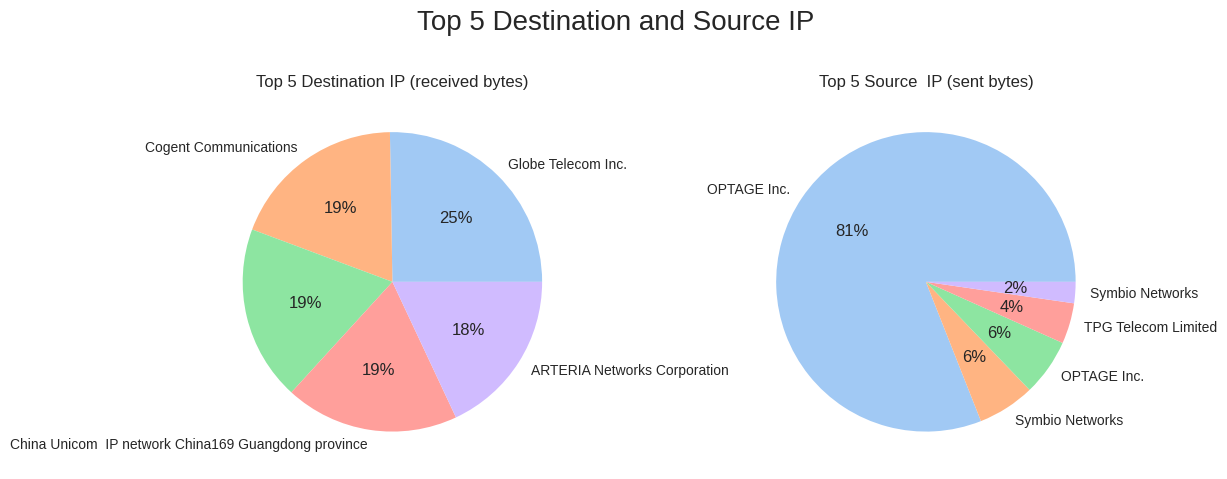

In [15]:
# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
#Let's make... a cake!
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

# Plot the first pie chart on the first subplot
axes[0].pie(top_5_destination.get_column("len"),
            labels=top_5_destination.get_column("organization"),
            colors=colors, autopct='%.0f%%')
axes[0].set_title('Top 5 Destination IP (received bytes)')

# Plot the second pie chart on the second subplot labels = sent.iloc[:, 3]
axes[1].pie(top_5_source.get_column("len"),
            labels=top_5_source.get_column("organization"),
            colors=colors, autopct='%.0f%%')
axes[1].set_title('Top 5 Source  IP (sent bytes)')

# Add a common title for the subplots
fig.suptitle('Top 5 Destination and Source IP', fontsize=20)

# Adjust the spacing between subplots
fig.tight_layout()
plt.savefig("top_5_dst_src_ip.svg", format='svg', bbox_inches = "tight")
# Display the plot
plt.show()

In [16]:
with pl.Config(fmt_str_lengths=30):
    display(top_5_source)

src,len,localization,organization
str,i64,list[str],str
"""150.57.136.251""",770625821,"[""Kadoma"", ""JP""]","""OPTAGE Inc."""
"""203.122.131.143""",58805957,"[""Adelaide"", ""AU""]","""Symbio Networks"""
"""150.57.242.48""",58410619,"[""Kadoma"", ""JP""]","""OPTAGE Inc."""
"""202.7.174.242""",41799728,"[""Mandurah"", ""AU""]","""TPG Telecom Limited"""
"""203.122.136.47""",21836101,"[""Adelaide"", ""AU""]","""Symbio Networks"""


From the previous pieplot it's interesting notice that OPTAGE Inc. (Japanase company) has considerable dominance when it comes to bytes sent. We try to extract in relation to all IP addresses what kind of weight this company has:

In [17]:
ratio = round( (top_5_source
                .filter(pl.col("organization")=="OPTAGE Inc.")
                .get_column("len")
                .sum()) / df.get_column("len").sum(), 3)

print(f'The ratio among bytes sent by OPTAGE Inc. and all the other IPv4 of this 1M sample is {ratio}')

The ratio among bytes sent by OPTAGE Inc. and all the other IPv4 of this 1M sample is 0.752


In [18]:
quantile_pack = (df
                 .lazy()
                 .groupby(by="dst")
                 .quantile(0.95)
                 .select(pl.col("dst"),
                         pl.col("len"))
                 .sort("len", descending=True)
                 .head(10)).collect()

quantile_pack = add_infos(quantile_pack, "dst").sort(["len", "organization"], descending=True).head(5)

with pl.Config(fmt_str_lengths=30):
    display(quantile_pack)

dst,len,localization,organization
str,f64,list[str],str
"""112.137.94.159""",5880.0,"[""Tachikawa"", ""JP""]","""JCOM Co., Ltd."""
"""159.95.122.206""",5880.0,"[""Rue"", ""FR""]","""BNP PARIBAS S.A."""
"""45.207.59.1""",5844.0,"[""Hong Kong"", ""HK""]","""SonderCloud Limited"""
"""118.156.70.141""",5844.0,"[""Kawasaki"", ""JP""]","""KDDI CORPORATION"""
"""182.244.245.217""",5844.0,"[""Kunming"", ""CN""]","""CHINANET-BACKBONE"""


### 5) Evaluate bitRate considering all the trace with 3 different sampling rate

We have decided to perform as different sampling rates:

- 0.01 seconds
- 0.1 seconds
- 0.5 seconds

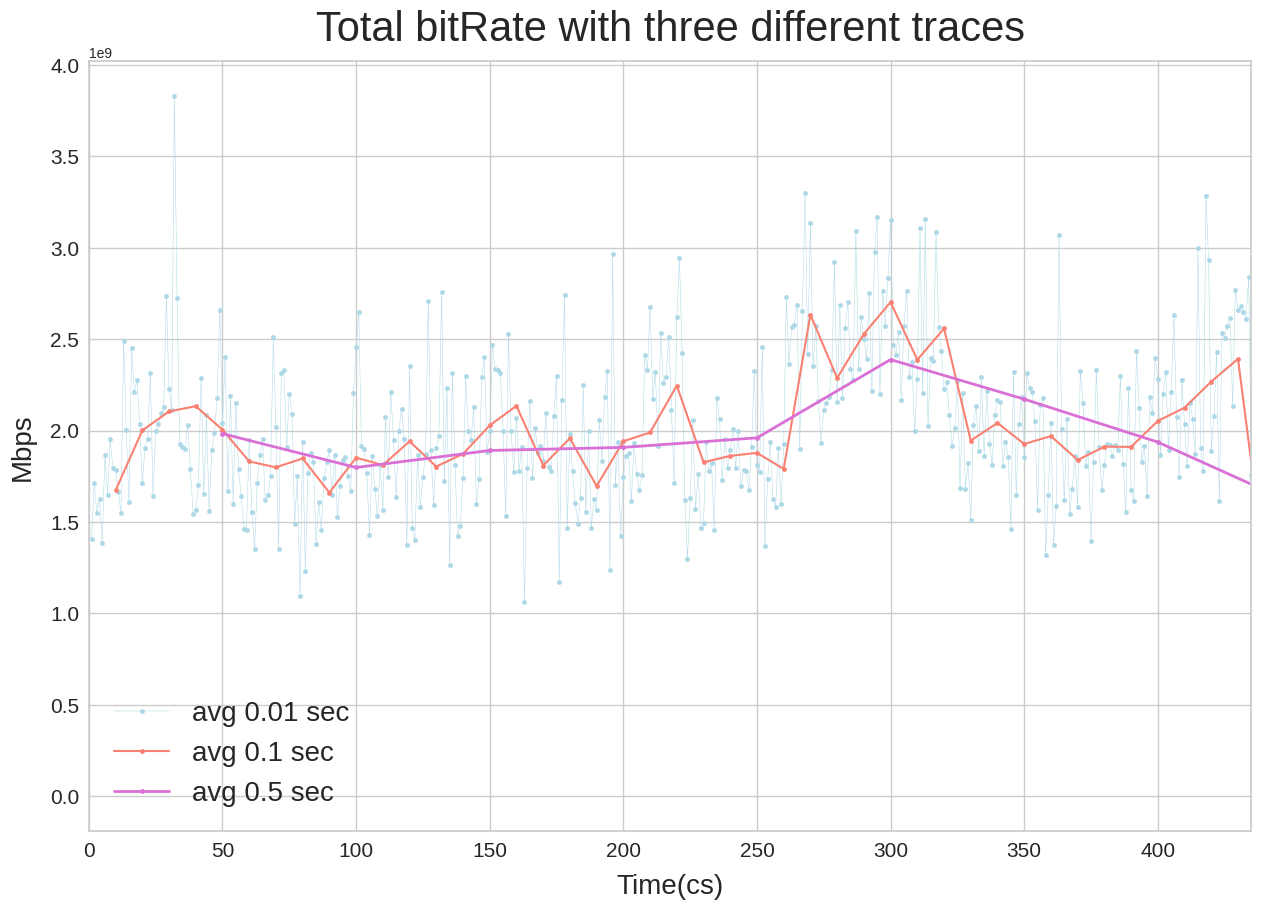

In [19]:
plt.figure(figsize = (15, 10))

bitrate_1 = bit_rate(df, 0.01)
bitrate_2 = bit_rate(df, 0.1)
bitrate_3 = bit_rate(df, 0.5)

plt.plot(list(range(1, len(bitrate_1)+1)), bitrate_1, marker=".", label = "avg 0.01 sec", color='lightblue', lw = 0.35)
plt.plot(list(range(10, len(bitrate_2)*10+1, 10)), bitrate_2, marker=".", label = "avg 0.1 sec", color='salmon', lw = 1.5)
plt.plot(list(range(50, len(bitrate_3)*50+1, 50)), bitrate_3, marker=".", label = "avg 0.5 sec", color='orchid', lw = 2)

# Set x-axis limits
delta = round(df.get_column("sniff_timestamp").max() - df.get_column("sniff_timestamp").min(), 2)*100
    
plt.xlim(0, round(delta, 0))
plt.xlabel('Time(cs)', fontsize = 20, labelpad = 10)
plt.ylabel('Mbps', fontsize = 20, labelpad = 10)
plt.title('Total bitRate with three different traces', fontsize = 30, pad = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize=20, loc="best")
plt.savefig("total_bitrace.svg", format='svg', bbox_inches = "tight")
plt.show()

### 6) GeoLocal Referenciation of the 5 sessions with the highest amount of traffic generated

#### Auxiliary functions:

In [20]:
def geo_infos(dataframe: pl.DataFrame,
              columns: list[str]):
    """Get the geo informations of the passed IPs.

    Args:
        - dataframe (pl.DataFrame): A polars.DataFrame containing the IPs.
        - columns (list[str]): List of the columns.

    Returns:
        - temp (pl.DataFrame): A polars.DataFrame containing for each IP its latitude, longitude and region.
    """
    unique_ip = set()

    for col in columns:
        unique_ip.update(dataframe.get_column(col).unique().to_list())

    info = {'ip': [],
            'latitude': [],
            'longitude': [],
            'region': []}
    for ip in tqdm(unique_ip):
        try:
            if (resp:=DbIpCity.get(ip, api_key='free')) == None: continue
            info['ip'].append(ip)
            info['latitude'].append(resp.latitude)
            info['longitude'].append(resp.longitude)
            info['region'].append(resp.region)
        except:
            continue

    temp = pl.DataFrame(info)
    return temp

#### Extract the highest amount of traffic generated by each session

In [21]:
the_5_sessions_highest_traffic = (df
                                  .lazy()
                                  .groupby(by=['src', 'dst', 'proto', 'srcport', 'dstport'])
                                  .agg(pl.col('len').sum())
                                  .sort(by='len', descending=True)
                                  .head(5)).collect()

with pl.Config(fmt_str_lengths=30):
    display(the_5_sessions_highest_traffic)

src,dst,proto,srcport,dstport,len
str,str,i64,i64,i64,i64
"""150.57.136.251""","""222.127.201.52""",6,80,62620,57298442
"""150.57.136.251""","""66.132.46.70""",6,873,8878,43199416
"""150.57.136.251""","""221.246.5.50""",6,80,2447,40872400
"""150.57.136.251""","""39.18.205.141""",6,80,64480,28122433
"""150.57.136.251""","""221.244.225.179""",6,80,64918,28033031


#### Get the geo informations for the IPs:

In [22]:
geo_inf_dataframe = geo_infos(the_5_sessions_highest_traffic, ['src', 'dst'])

with pl.Config(fmt_str_lengths=30):
    display(geo_inf_dataframe)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.64it/s]


ip,latitude,longitude,region
str,f64,f64,str
"""150.57.136.251""",35.69381,139.753216,"""Tokyo"""
"""221.246.5.50""",35.69381,139.753216,"""Tokyo"""
"""66.132.46.70""",40.886016,-74.007257,"""New Jersey"""
"""39.18.205.141""",37.359913,127.108045,"""Gyeonggi-do"""
"""221.244.225.179""",35.69381,139.753216,"""Tokyo"""
"""222.127.201.52""",14.527054,121.074494,"""National Capital Region"""


#### Create dataframe with geo informations for both source and destination IPs:

In [23]:
src_geo = the_5_sessions_highest_traffic.join(geo_inf_dataframe,
                                              left_on='src',
                                              right_on='ip').select(pl.col('src'),
                                                                    pl.col('latitude'),
                                                                    pl.col('longitude'),
                                                                    pl.col('region'))

dst_geo = the_5_sessions_highest_traffic.join(geo_inf_dataframe,
                                              left_on='dst',
                                              right_on='ip').select(pl.col('src'),
                                                                    pl.col('latitude'),
                                                                    pl.col('longitude'),
                                                                    pl.col('region'))

#### Display the folium map:

In [24]:
# Create a map centered on the source coordinates (Tokyo)
folium_map = folium.Map(location=[src_geo.get_column('latitude').mean(),
                                  src_geo.get_column('longitude').mean()], zoom_start=4)

# Create a marker cluster group to group the markers
marker_cluster = MarkerCluster().add_to(folium_map)

for row in the_5_sessions_highest_traffic.iter_rows(named=True):
    src_lat, src_long, src_region = (tuple(geo_inf_dataframe.filter(pl.col('ip')==row['src']).select(pl.col('latitude'),
                                                                                                     pl.col('longitude'),
                                                                                                     pl.col('region')).get_columns()))
    dst_lat, dst_long, dst_region = (tuple(geo_inf_dataframe.filter(pl.col('ip')==row['dst']).select(pl.col('latitude'),
                                                                                                     pl.col('longitude'),
                                                                                                     pl.col('region')).get_columns()))

    source = (src_lat.item(0), src_long.item(0))
    destination = (dst_lat.item(0), dst_long.item(0))
    
    # Create a polyline connecting the source and destination
    polyline = folium.PolyLine(locations=[source, destination], color='salmon', dash_array='5, 5')
    folium_map.add_child(polyline)

    # Add markers at source and destination locations
    folium.Marker(location=source, popup='Source: ' + src_region.item(0), icon=folium.Icon(color='green', icon='circle')).add_to(marker_cluster)
    folium.Marker(location=destination, popup='Destination: ' +  dst_region.item(0), icon=folium.Icon(color='red', icon='square')).add_to(marker_cluster)

# Save the map to an HTML file
folium_map.save('connection_map.html')
display(folium_map)

### 7) 10 Protocol mostly used

First of all we retrieve the list of IP protocols with their respective codes, available at the [Internet Assigned Numbers Authority](https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml).

In [25]:
proto_to_protocols_df = pd.read_html('https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml', match='Decimal').pop()[['Decimal', 'Protocol', 'Keyword']]
proto_to_protocols_df

,Decimal,Protocol,Keyword
0,0,IPv6 Hop-by-Hop Option,HOPOPT
1,1,Internet Control Message,ICMP
2,2,Internet Group Management,IGMP
3,3,Gateway-to-Gateway,GGP
4,4,IPv4 encapsulation,IPv4
...,...,...,...
145,145,Network Service Header,NSH
146,146-252,Unassigned,NaN
147,253,Use for experimentation and testing,NaN
148,254,Use for experimentation and testing,NaN


The `Decimal` column contains the protocol number code, which is number between 0 and 255.

We can notice a major problem tho: some protocols doesn't have an unique code, but multiple... for this reason we're going to clean the dataframe with the following funtion.

In [26]:
def clear_df(dataframe: pd.DataFrame) -> pd.DataFrame:
    """A function that search for all the protocols that have multiple decimal code (e.g. 146-252) and then returns
    a cleaned version of the dataframe in which those protocols appear one time for each decimal code.

    Args:
        - dataframe (pd.DataFrame): The original pandas.DataFrame.

    Returns:
        - df (pd.DataFrame): The cleaned version of 'dataframe'.
    """
    # Get a copy of dataframe
    df = dataframe.copy()

    # For each protocols that contains '-' in the Decimal column (has multiple Decimal codes)
    for prt in dataframe[dataframe.Decimal.str.contains('-')]['Protocol']:
        # Get first and last codes
        first, last = tuple(map(int, dataframe[dataframe.Protocol == prt].Decimal.item().split('-')))
        # Get the Keyword
        keyw = dataframe[dataframe.Protocol == prt].Keyword.item()
        # Create a temporary pandas.DataFrame with the Protcl repeated for each Decimal code 
        temp = pd.DataFrame({'Decimal': list(range(first, last+1)),
                             'Protocol': prt,
                             'Keyword': keyw})
        # Remove the Protocol from the original copy
        df = df[df.Protocol != prt]
        # Concat the temporary dataframe to the copy
        df = pd.concat([df, temp], ignore_index=True)
    # Set the type of the Decimal column to numeric
    df['Decimal'] = df['Decimal'].apply(pd.to_numeric)
    # Return the sorted cleaned dataframe
    return df.sort_values(by="Decimal", ignore_index=True).set_index('Decimal')

In [27]:
proto_to_protocols_df = clear_df(proto_to_protocols_df)
display(proto_to_protocols_df)

,Protocol,Keyword
Decimal,,
0,IPv6 Hop-by-Hop Option,HOPOPT
1,Internet Control Message,ICMP
2,Internet Group Management,IGMP
3,Gateway-to-Gateway,GGP
4,IPv4 encapsulation,IPv4
...,...,...
251,Unassigned,NaN
252,Unassigned,NaN
253,Use for experimentation and testing,NaN


10 Protocol mostly used


,proto,count,Protocol,Keyword
0,6,947884,Transmission Control,TCP
1,17,38749,User Datagram,UDP
2,1,13159,Internet Control Message,ICMP
3,50,117,Encap Security Payload,ESP
4,97,70,Ethernet-within-IP Encapsulation,ETHERIP
5,4,9,IPv4 encapsulation,IPv4
6,47,6,Generic Routing Encapsulation,GRE
7,89,5,OSPFIGP,OSPFIGP
8,103,1,Protocol Independent Multicast,PIM


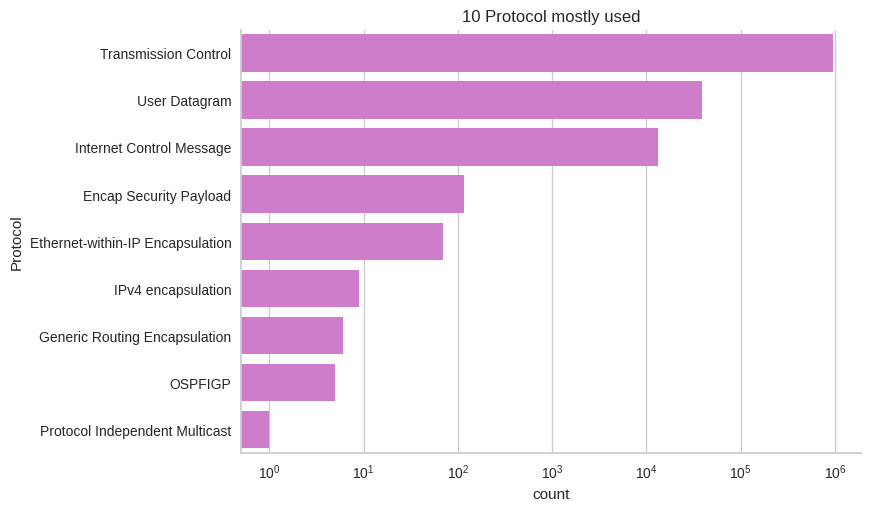

In [28]:
most_used_protocol_10 = (df
                        .lazy()
                        .groupby(by="proto")
                        .count()
                        .sort(by="count", descending=True)
                        .head(10)).collect()

most_used_protocol_10 = pd.merge(most_used_protocol_10.to_pandas(), proto_to_protocols_df, how='left', left_on="proto", right_on="Decimal")

print("10 Protocol mostly used")
display(most_used_protocol_10)

plot = sns.barplot(most_used_protocol_10,
                   x="count",
                   y="Protocol",
                   color="orchid",
                   orient='h',
                   order=most_used_protocol_10["Protocol"].to_numpy())
plot.set(title="10 Protocol mostly used",
         ylabel="Protocol",
         xscale="log")
sns.despine()
plt.savefig("10_mostly_used_protocol.svg", format='svg', bbox_inches = "tight")
plt.show()

In the plot above there are only 9 protocols displayed because we are analysing only the first 1 million packets: by running the code above on the entire dataset we'll find that the 10th protocol is **Internet Group Management**. 

### 8) Port Scanner evaluation (10 Ports mostly used)

Top 10 port used:


port,dst,src,total
i64,u32,u32,u32
443,183777,259533,443310
80,97235,330326,427561
52038,63977,0,63977
62620,26317,15304,41621
44101,37330,1,37331
8080,45,31995,32040
-1,13407,13407,26814
2447,25871,0,25871
873,4636,21026,25662


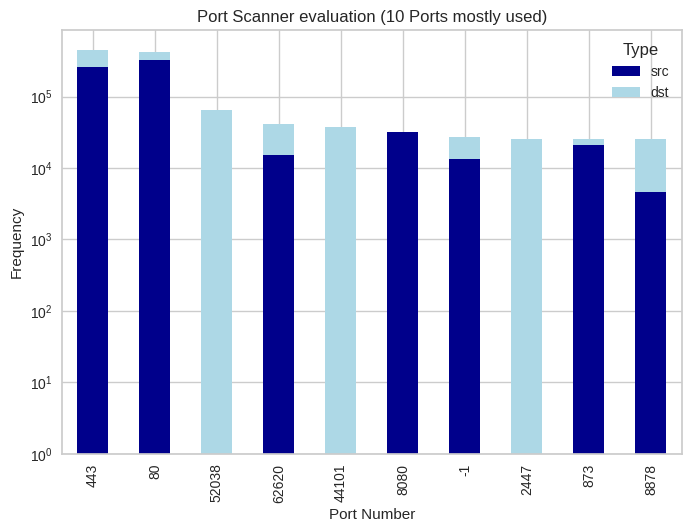

In [29]:
all_ports = (df
             .lazy()
             .melt(value_vars=['srcport', 'dstport'],
                   variable_name='type',
                   value_name='port')
             .with_columns(pl.col("type").str.replace("port", ""))
             .collect())

top_10_ports = (all_ports
                .lazy()
                .groupby('port')
                .count()
                .sort(by='count', descending=True)
                .head(10)
                .collect())

# Get the final dataframe with the specific count for each type of port and port
top_10_ports_final = (top_10_ports
                     .join(all_ports, on='port', how="left")
                     .lazy()
                     .groupby(['type', 'port'])
                     .count()
                     .sort(by=['port', 'type'])
                     .collect()
                     .pivot(index='port',
                            columns='type',
                            values='count',
                            aggregate_function=None)
                     .fill_null(0)
                     .with_columns(total=pl.col("dst")+pl.col("src"))
                     .sort(by='total', descending=True))

print("Top 10 port used:")
display(top_10_ports_final)

# Plot the stacked barplot using pandas
top_10_ports_final.to_pandas().set_index('port')[['src', 'dst']].plot(kind='bar',
                                                                      stacked=True,
                                                                      color=['darkblue', 'lightblue'],
                                                                      logy=True)

plt.title("Port Scanner evaluation (10 Ports mostly used)")
plt.xlabel("Port Number")
plt.ylabel("Frequency")
plt.legend(title='Type')
plt.savefig("port_scanner.svg", format='svg', bbox_inches = "tight")
plt.show()

### 9) InterArrival Time boxplot between TCP and UDP Sessions

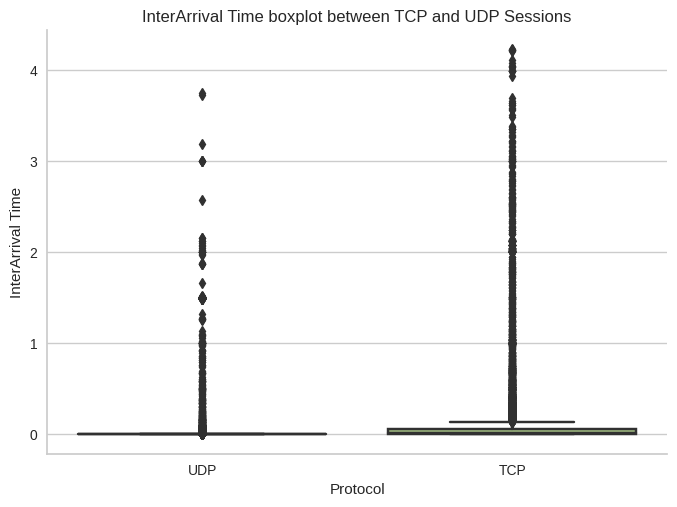

In [30]:
interarrival_time = (df
                     .lazy()
                     .filter((pl.col('proto')==6)|(pl.col('proto')==17))
                     .sort('sniff_timestamp')
                     .groupby(['src', 'dst', 'proto', 'srcport', 'dstport'], maintain_order=True)
                     .agg(pl.col('sniff_timestamp').diff().mean())
                     .fill_null(0)
                     .collect())

plot = sns.boxplot(pd.merge(interarrival_time.to_pandas(), proto_to_protocols_df, how='left', left_on="proto", right_on="Decimal"),
                   y='sniff_timestamp',
                   x='Keyword')

plot.set(title='InterArrival Time boxplot between TCP and UDP Sessions',
         ylabel='InterArrival Time',
         xlabel='Protocol')
sns.despine()
plt.savefig("IAT_boxplot.svg", format='svg', bbox_inches = "tight")
plt.show()

#### 10) Develope your own analysis (e.g. Topology of the network using networkx or evaluation about a variable such as TTL) (BONUS)

To analyse the topology of the network we have written a specific script (`src/topology_analysis.py`) which uses [graph-tool](https://graph-tool.skewed.de/), a python library specialized in graph analysis (it is not present in the `.venv` enviroment because it can't be installed with `pip`, more [here](https://graph-tool.skewed.de/download)).

To run the script, in the terminal from the root directory:

```bash
python src/topology_analysis.py
```

This will perform the entire analysis and save each plot in the root directory.

#### TCP and UDP networks

We decided to focus our analysis only on the TCP and UDP protocols.

|Network|Num. Nodes|Num. Edges|Diameter|Num. Components|Global Clustering|
|-------|---------:|---------:|-------:|--------------:|----------------:|
|**TCP**|10080     |19969     |13      |8741           |0                |
|**UDP**|11622     |16787     |16      |10467          |0                |

<div style="display:flex; justify-content: center;">
         <div style="flex:1;padding-right:10px; text-align: center;">
             <p style="text-align: center;"><strong>TCP Network</strong></p>
             <img src="img/tcp_network.svg" alt="TCP network" style="width:70%">
         </div>
         <div style="flex:1;padding-left:10px; text-align: center;">
             <p style="text-align: center;"><strong>UDP Network</strong></p>
             <img src="img/udp_network.svg" alt="UDP network" style="width:70%">
         </div>
</div>

|Largest Component|Num. Nodes|Num. Edges|% over total nodes|% over total edges|Global Clustering|
|-----------------|---------:|---------:|-----------------:|-----------------:|----------------:|
|**TCP**          |922       |3397      |9.15%             |17.01%            |0                |
|**UDP**          |1086      |3004      |9.34%             |17.89%            |0                |

<div style="display:flex; justify-content: center;">
         <div style="flex:1;padding-right:10px; text-align: center;">
             <p style="text-align: center;"><strong>TCP Largest Component</strong></p>
             <img src="img/tcp_largest_component.svg" alt="TCP largest component" style="width:80%">
         </div>
         <div style="flex:1;padding-left:10px; text-align: center;">
             <p style="text-align: center;"><strong>UDP Largest Component</strong></p>
             <img src="img/udp_largest_component.svg" alt="UDP largest component" style="width:80%">
         </div>
</div>

> **Note**: The fact that the global clustering coefficient is equal to zero means that in the network there are no triplets or triangles.

<div align="center">
  <img src='img/degree_distribution.svg' width='40%' heigth='40%'>
</div>

> **Note**: Both networks degree distributions follow a power law behaviour.

<br/><br/>

<div align="center">
  <img src='img/components_nodes_distribution.svg' width='60%' heigth='60%'>
</div>


## Section B

### Auxiliary Functions

In [31]:
def show_performance(y_test: np.array,
                     y_pred: np.array) -> None:
    """This function shows the performance of a classifier.

    Args:
        - y_test (np.array): The true label of the observation
        - y_pred (np.array): The prediction of the classifier.

    Returns:
        - None
    """

    # Classification report
    print("Classification report:")
    print(classification_report(y_true=y_test, y_pred=y_pred, labels=[0, 1]))

    # Get ROC, auc and Confusion Matrix
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Confusion Matrix plot
    sns.heatmap(cm, annot=True, cmap='viridis', fmt='d', cbar=False, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # ROC plot
    axes[1].plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    axes[1].plot([0, 1], [0, 1], 'k--', label="chance level (AUC = 0.5)")
    axes[1].set_title('ROC Curve')
    axes[1].set_xlabel('1- Specificity')
    axes[1].set_ylabel('Sensitivity')
    axes[1].legend(loc='lower right')

    fig.suptitle("Performance", fontsize=18)
    plt.tight_layout()
    plt.show()

### Features Engineering

In [32]:
features_df = (df
              .lazy()
              .filter((pl.col('proto')==6)|(pl.col('proto')==17))
              .with_columns(
                  data_len=pl.col('len')-pl.col('hdr_len'))
              .sort('sniff_timestamp')
              .groupby(['dst', 'dstport', 'proto'], maintain_order=True)
              .agg(
                   # Len of the packets
                   len_sum=pl.col('len').sum(),
                   len_max=pl.col('len').max(),
                   len_min=pl.col('len').min(),
                   len_mean=pl.col('len').mean(),
                   len_median=pl.col('len').median(),
                   len_std=pl.col('len').std(),
                   # Len of the headers
                   hdr_len_sum=pl.col('hdr_len').sum(),
                   # Len of the data
                   data_len_sum=pl.col('data_len').sum(),
                   data_len_max=pl.col('data_len').max(),
                   data_len_min=pl.col('data_len').min(),
                   data_len_mean=pl.col('data_len').mean(),
                   data_len_median=pl.col('data_len').median(),
                   data_len_std=pl.col('data_len').std(),
                   # flags_df
                   flags_df=pl.col('flags_df').sum(),
                   # Time to live
                   ttl_sum=pl.col('ttl').sum(),
                   ttl_mean=pl.col('ttl').mean(),
                   # Number of packets
                   n_packets=pl.count(),
                   # Duration
                   flow_duration=pl.col('sniff_timestamp').max()-pl.col('sniff_timestamp').min(),
                   # The InterArrivalTime
                   IAT=pl.col('sniff_timestamp').diff().mean(),
                   IAT_median=pl.col('sniff_timestamp').diff().fill_null(0).median(),
                   IAT_max=pl.col('sniff_timestamp').diff().max(),
                   IAT_std=pl.col('sniff_timestamp').diff().fill_null(0).std())
              .with_columns(
                  proto=pl.when(pl.col("proto")
                        .eq(pl.lit(6)))
                        .then(pl.lit(1))
                        .otherwise(pl.lit(0)),
                  dst=pl.col('dst').apply(lambda ip: int(ipaddress.IPv4Address(ip))))
              .fill_null(0)
              ).collect()

print(features_df)

shape: (12_224, 25)
┌────────────┬─────────┬───────┬──────────┬───┬──────────┬────────────┬──────────┬──────────┐
│ dst        ┆ dstport ┆ proto ┆ len_sum  ┆ … ┆ IAT      ┆ IAT_median ┆ IAT_max  ┆ IAT_std  │
│ ---        ┆ ---     ┆ ---   ┆ ---      ┆   ┆ ---      ┆ ---        ┆ ---      ┆ ---      │
│ i64        ┆ i64     ┆ i32   ┆ i64      ┆   ┆ f64      ┆ f64        ┆ f64      ┆ f64      │
╞════════════╪═════════╪═══════╪══════════╪═══╪══════════╪════════════╪══════════╪══════════╡
│ 2206826009 ┆ 48350   ┆ 0     ┆ 95       ┆ … ┆ 0.0      ┆ 0.0        ┆ 0.0      ┆ 0.0      │
│ 3723813299 ┆ 64918   ┆ 1     ┆ 28033031 ┆ … ┆ 0.00024  ┆ 0.000017   ┆ 0.151407 ┆ 0.00125  │
│ 3413805103 ┆ 80      ┆ 1     ┆ 412316   ┆ … ┆ 0.000552 ┆ 0.000099   ┆ 0.007624 ┆ 0.000994 │
│ 2605068484 ┆ 27023   ┆ 0     ┆ 20441    ┆ … ┆ 0.033399 ┆ 0.033307   ┆ 0.051868 ┆ 0.007155 │
│ …          ┆ …       ┆ …     ┆ …        ┆ … ┆ …        ┆ …          ┆ …        ┆ …        │
│ 3525053427 ┆ 4528    ┆ 0     ┆ 75     

### Correlation Matrix

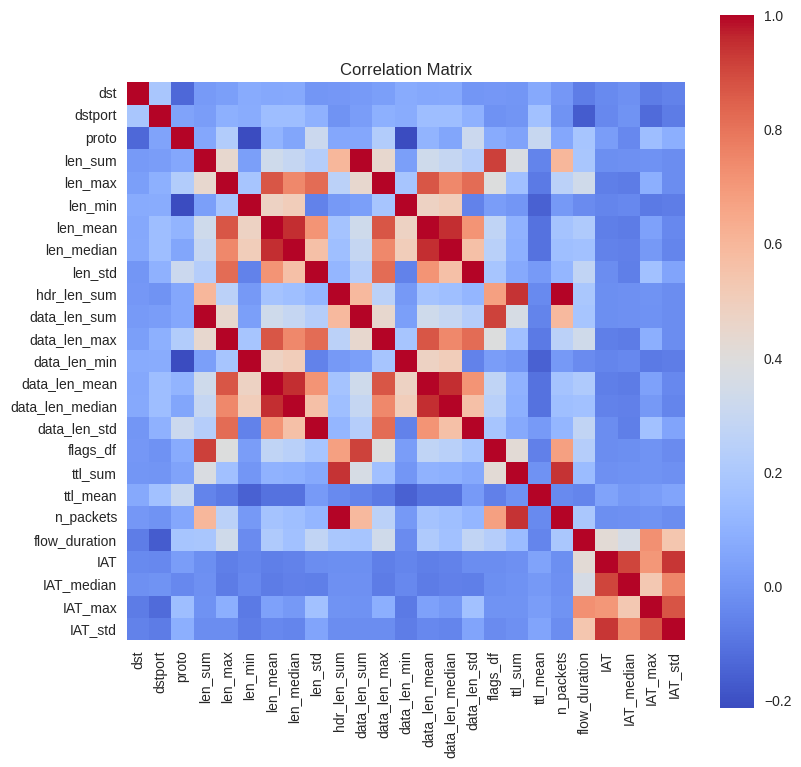

In [33]:
plt.figure(figsize = (9,9))
plot = sns.heatmap(features_df.corr().to_pandas().set_index(pd.Series(features_df.columns)),
                   cmap='coolwarm',
                   square=True)
plot.set(title='Correlation Matrix')
plt.savefig("cm_stats_features.svg", format='svg', bbox_inches = "tight")
plt.show()

### Protocol Distribution

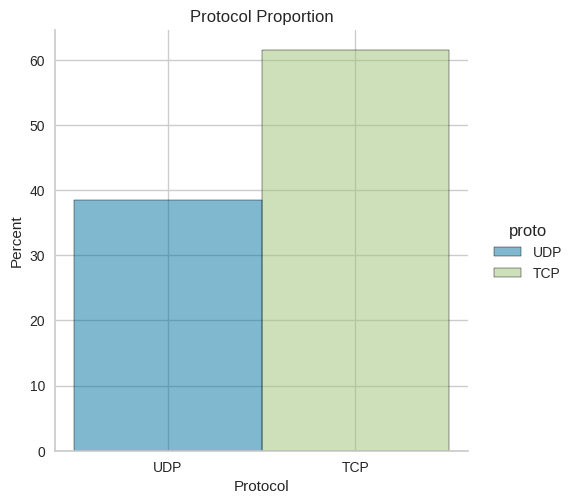

In [34]:
plot = sns.displot(features_df.with_columns(proto=pl.when(pl.col("proto").eq(pl.lit(1))).then(pl.lit('TCP')).otherwise(pl.lit('UDP'))).to_pandas(),
                   x='proto',
                   hue='proto',
                   stat='percent')
plot.set(title='Protocol Proportion',
         xlabel='Protocol')
plt.savefig("ptr_distr_flow.svg", format='svg', bbox_inches = "tight")
plt.show()

### Dividing into train and test set

In [35]:
seed = 42
train_df, test_df = train_test_split(features_df.to_pandas(), test_size=0.2, random_state=seed)

X_train = train_df.drop(['proto'], axis=1).to_numpy()
y_train = train_df['proto'].to_numpy()
X_test = test_df.drop(['proto'], axis=1).to_numpy()
y_test = test_df['proto'].to_numpy()

scaler = StandardScaler().fit(X_train)

### Performing PCA

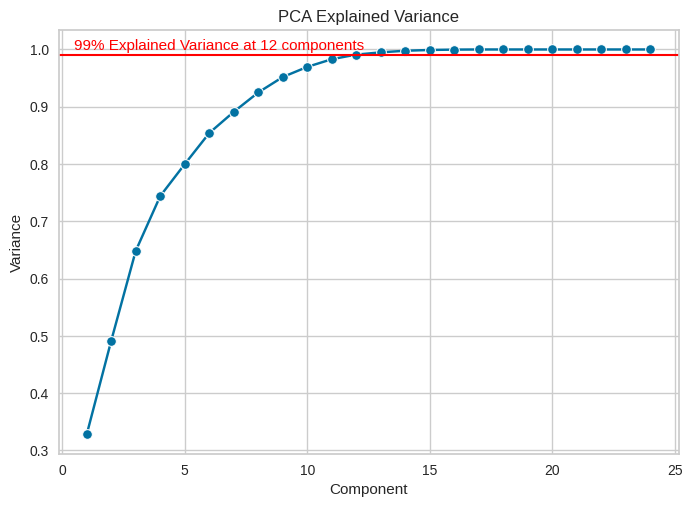

In [36]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

var = 0.99
pca = PCA().fit(X_train)

plot = sns.lineplot(x=range(1, pca.explained_variance_ratio_.shape[0]+1),
                    y=np.cumsum(pca.explained_variance_ratio_),
                    marker='o')
plot.set(title='PCA Explained Variance',
         xlabel='Component',
         ylabel='Variance')

pca_var = np.cumsum(pca.explained_variance_ratio_)
n_components = len(pca_var[pca_var<var])+1

plt.axhline(y=var, color='red', linestyle='-',linewidth=1.5)
plt.text(0.5, var+0.009, f'{int(var*100)}% Explained Variance at {n_components} components', color = 'red', fontsize=11)
plt.savefig("pca_stat_features.svg", format='svg', bbox_inches = "tight")
plt.show()

pca = PCA(var).fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

### Unsupervised Classification

#### TCP and UDP Clusters

Classification report:
              precision    recall  f1-score   support

           0       0.40      0.97      0.57       941
           1       0.83      0.09      0.16      1504

    accuracy                           0.43      2445
   macro avg       0.62      0.53      0.36      2445
weighted avg       0.67      0.43      0.32      2445



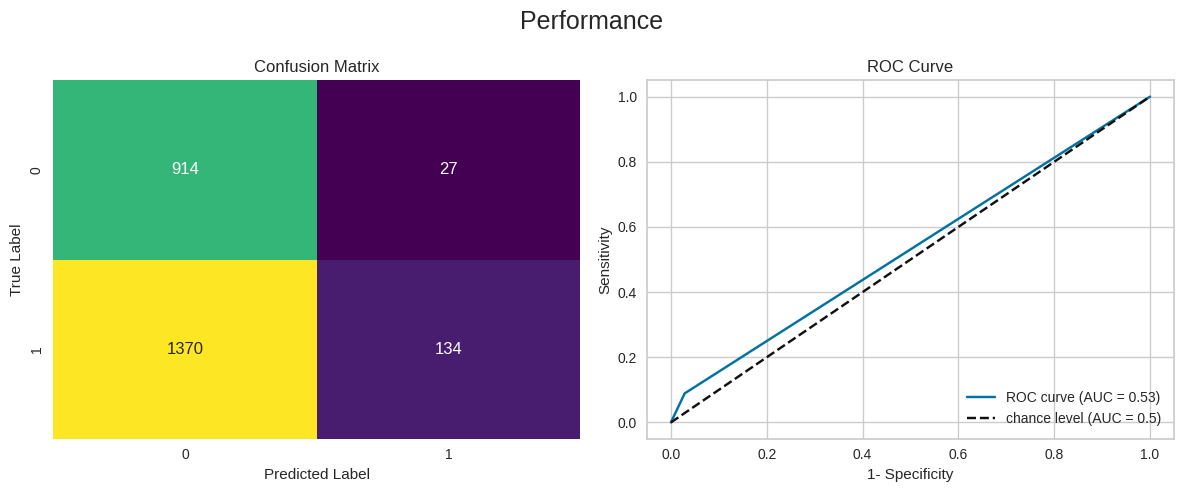

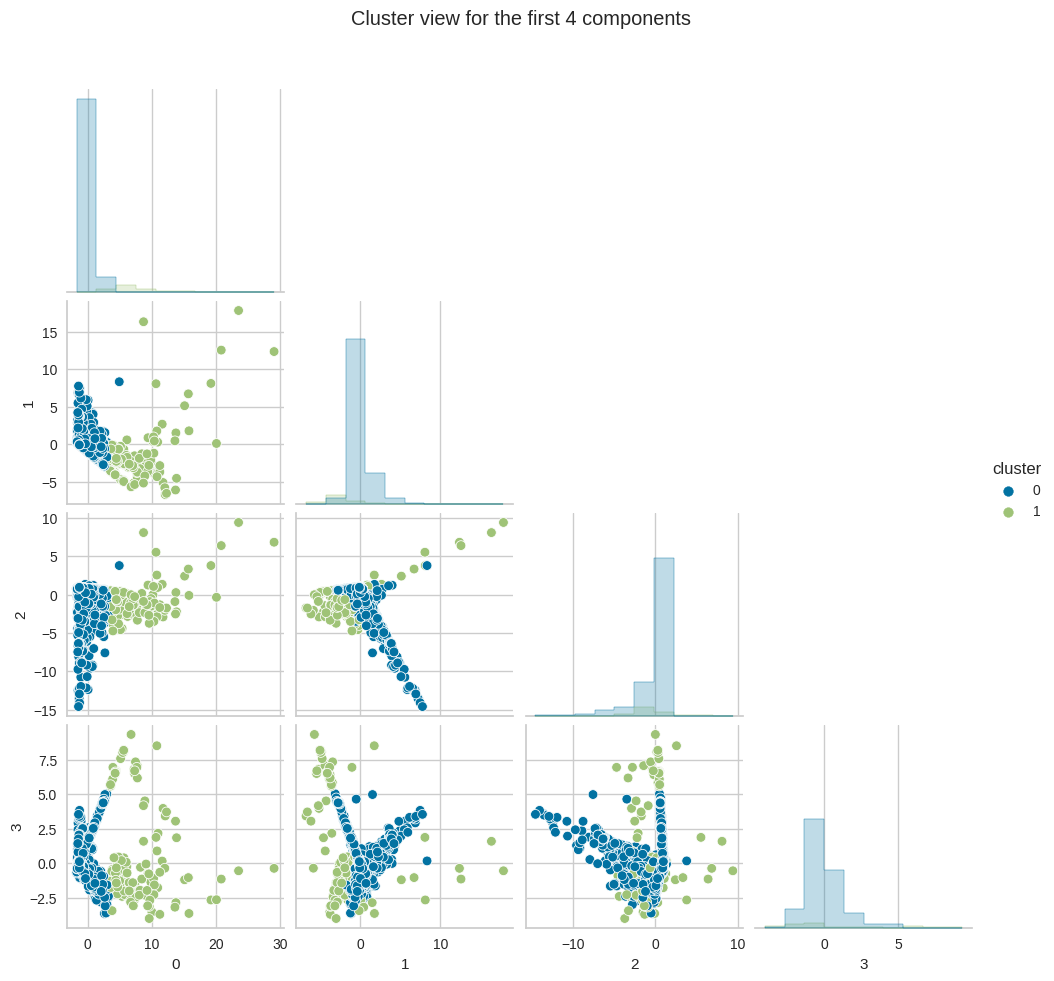

In [37]:
km_2 = KMeans(n_clusters=2, random_state=seed, n_init='auto')
km_2.fit(X_train)

y_pred = km_2.predict(X_test)

show_performance(y_test, y_pred)

c = 4
km_d = pd.DataFrame(X_test[:,0:c])
km_d['cluster'] = y_pred

print()
plot = sns.pairplot(km_d,
                    hue="cluster",
                    diag_kind='hist', 
                    corner=True,
                    diag_kws = {'bins':10, 'element':'step'})
plot.fig.suptitle(f'Cluster view for the first {c} components')
plot.fig.subplots_adjust(top=.9)
plt.savefig("kmeans_cluster_2.svg", format='svg', bbox_inches = "tight")
plt.show()

roc_df = pl.DataFrame()
prec_rec_df = pl.DataFrame()

fpr, tpr, _ = roc_curve(y_test, y_pred)
auc_score = round(auc(fpr, tpr), 2)
temp = pl.DataFrame({"fpr": fpr, "tpr": tpr, "Model": f'KMeans AUC: {auc_score}'})
roc_df = pl.concat([roc_df, temp])

precision, recall, _ = precision_recall_curve(y_test, y_pred)
temp = pl.DataFrame({"precision": precision, "recall": recall, "Model": f'KMeans AUC: {auc_score}'})
prec_rec_df = pl.concat([prec_rec_df, temp])

#### Elbow Method for optimal number of clusters

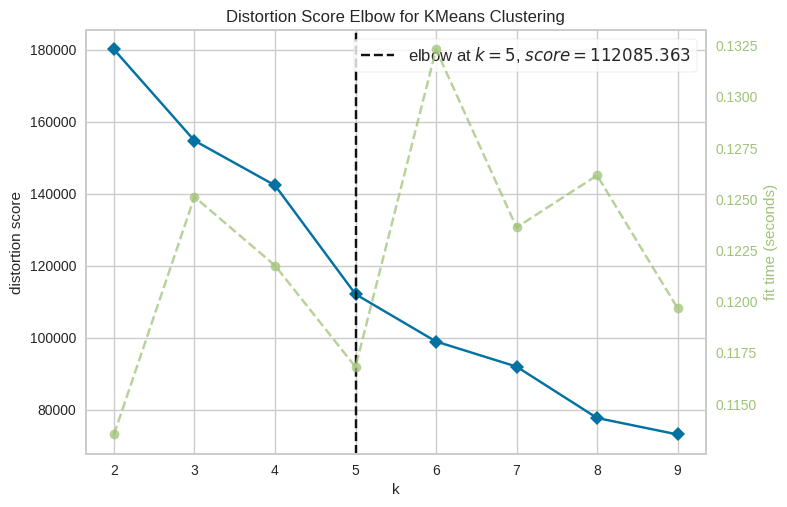

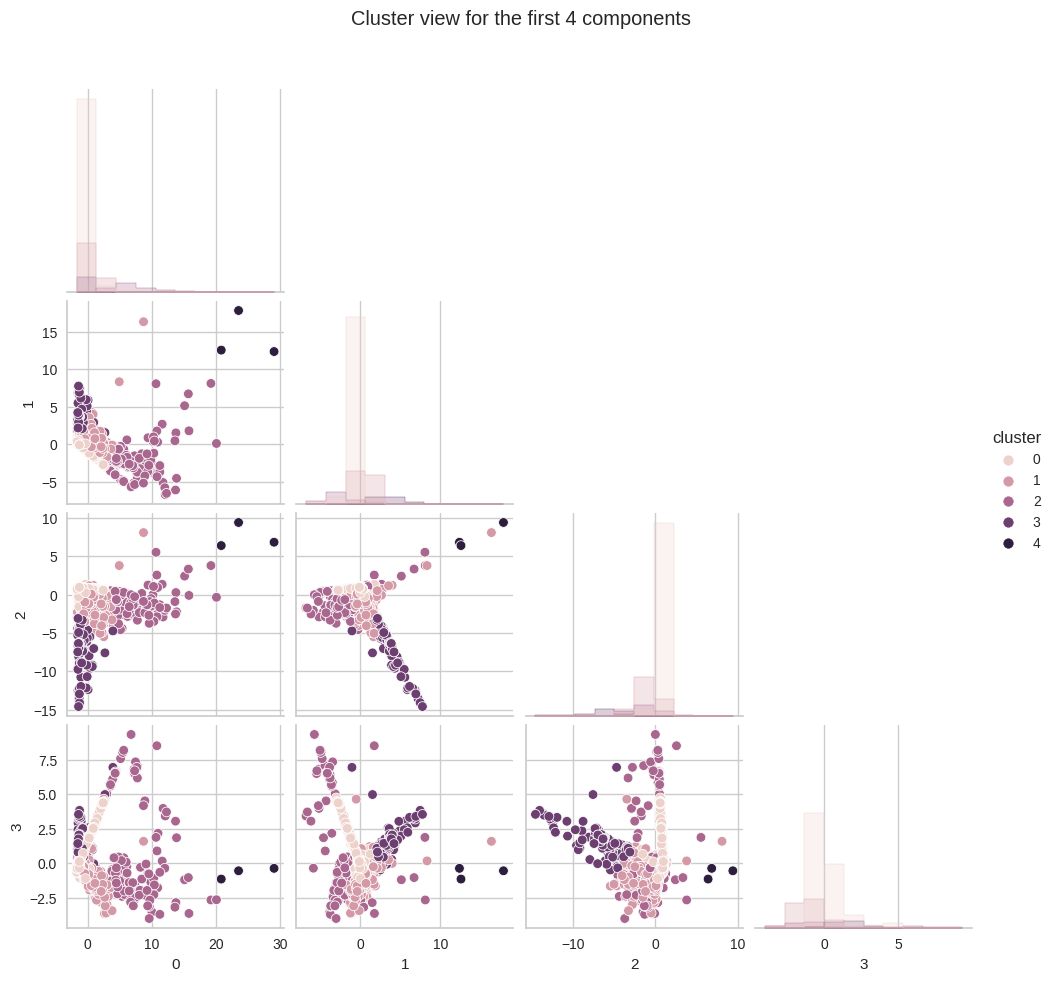

In [38]:
km = KMeans(random_state=seed, n_init='auto')
visualizer = KElbowVisualizer(km, k=(2,10))
visualizer.fit(X_train)
plt.savefig("kmneans_elbow_score.svg", format='svg', bbox_inches = "tight")
visualizer.show()
plt.show()

km = KMeans(n_clusters=5, random_state=seed, n_init='auto')
km.fit(X_train)

c = 4
km_d = pd.DataFrame(X_test[:,0:c])
km_d['cluster'] = km.predict(X_test)

print()
plot = sns.pairplot(km_d,
                    hue="cluster",
                    diag_kind='hist', 
                    corner=True,
                    diag_kws = {'bins':10, 'element':'step'})
plot.fig.suptitle(f'Cluster view for the first {c} components')
plot.fig.subplots_adjust(top=.9)
plt.savefig("kmeans_cluster_elbow.svg", format='svg', bbox_inches = "tight")
plt.show()

### Supervised

In [39]:
X_train = train_df.drop(['proto'], axis=1).to_numpy()
y_train = train_df['proto'].to_numpy()
X_test = test_df.drop(['proto'], axis=1).to_numpy()
y_test = test_df['proto'].to_numpy()

In [40]:
n_jobs = -1

configuration_mnb = {
    'clf__alpha': uniform(1, 10),
    'clf__fit_prior': [True, False],
    'clf__force_alpha': [True, False],
}

configuration_svc = {
    'clf__C': uniform(0, 10),
    'clf__kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
    'clf__degree': randint(1, 5),
    'clf__gamma': ['auto', 'scale']
}

configuration_xgbclf = {
    'clf__n_estimators': randint(10, 250),
    'clf__max_depth': randint(10, 100),
    'clf__max_leaves': randint(0, 10),
    'clf__grow_policy': ['depthwise', 'lossguide'],
    'clf__learning_rate': uniform(1e-6, 1e-3),
    'clf__booster': ['gbtree', 'gblinear', 'dart'],
    'clf__tree_method': ['exact', 'approx'],
    'clf__sampling_method': ['uniform', 'gradient_based']
}

param_distr = {
    'MultinomialNB': configuration_mnb,
    'SVC': configuration_svc,
    'XGBClassifier': configuration_xgbclf
}

classifiers = {
    'MultinomialNB': MultinomialNB(),
    'SVC': SVC(random_state=seed),
    'XGBClassifier': XGBClassifier(random_state=seed, objective='binary:logistic', n_jobs=n_jobs)
}

#### Same features of Unsupervised

##### Training

In [41]:
n_splits = 5
n_iter = 30

search = {}
for clf in tqdm(classifiers):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    if clf == 'MultinomialNB':
        pipeline = Pipeline([('scaler', StandardScaler()),
                             ('pca', PCA(var)),
                             ('normalizer', MinMaxScaler()),
                             ('clf', classifiers[clf])])
    else:
        pipeline = Pipeline([('scaler', StandardScaler()),
                             ('pca', PCA(var)),
                             ('clf', classifiers[clf])])
        
    random_search = RandomizedSearchCV(pipeline, param_distr[clf], cv=kf, random_state=seed, n_jobs=n_jobs, n_iter=n_iter)
    search[clf] = random_search.fit(X_train, y_train)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:17<00:00, 45.90s/it]


##### Performace

Performance of MultinomialNB:

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.72      0.66       941
           1       0.80      0.70      0.75      1504

    accuracy                           0.71      2445
   macro avg       0.70      0.71      0.70      2445
weighted avg       0.72      0.71      0.71      2445



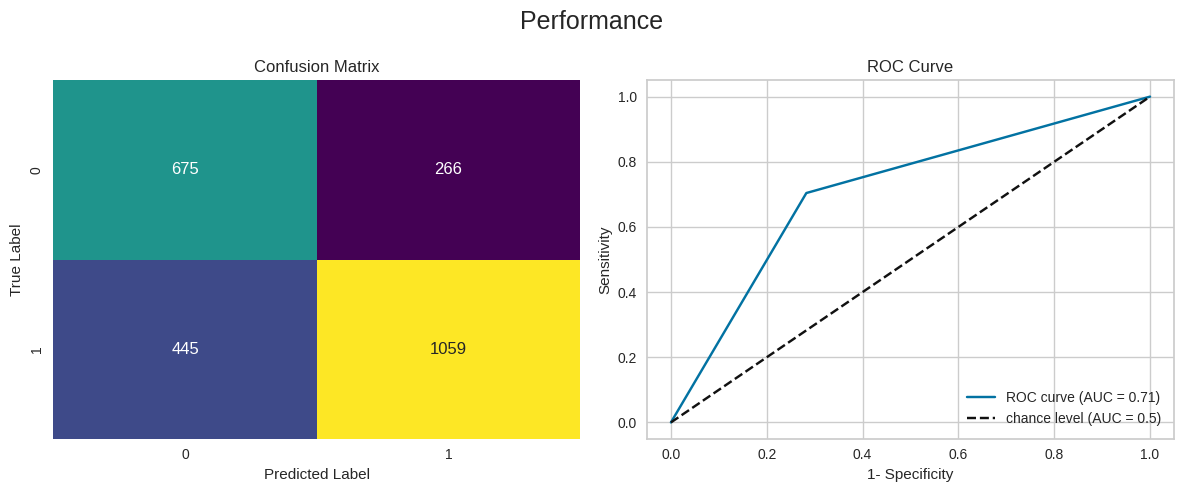



Performance of SVC:

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       941
           1       0.94      0.95      0.94      1504

    accuracy                           0.93      2445
   macro avg       0.93      0.92      0.93      2445
weighted avg       0.93      0.93      0.93      2445



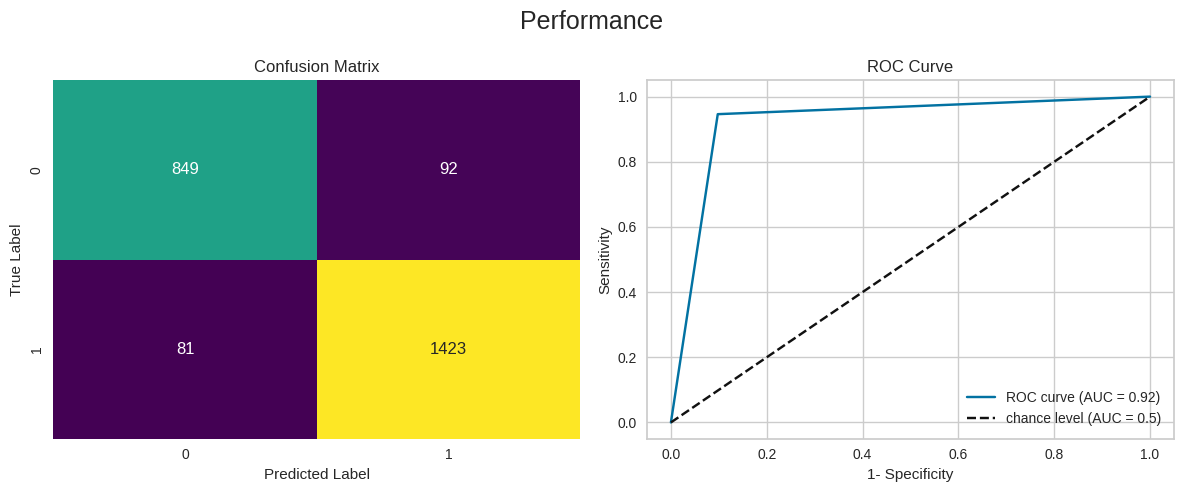



Performance of XGBClassifier:

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       941
           1       0.93      0.95      0.94      1504

    accuracy                           0.93      2445
   macro avg       0.92      0.92      0.92      2445
weighted avg       0.92      0.93      0.92      2445



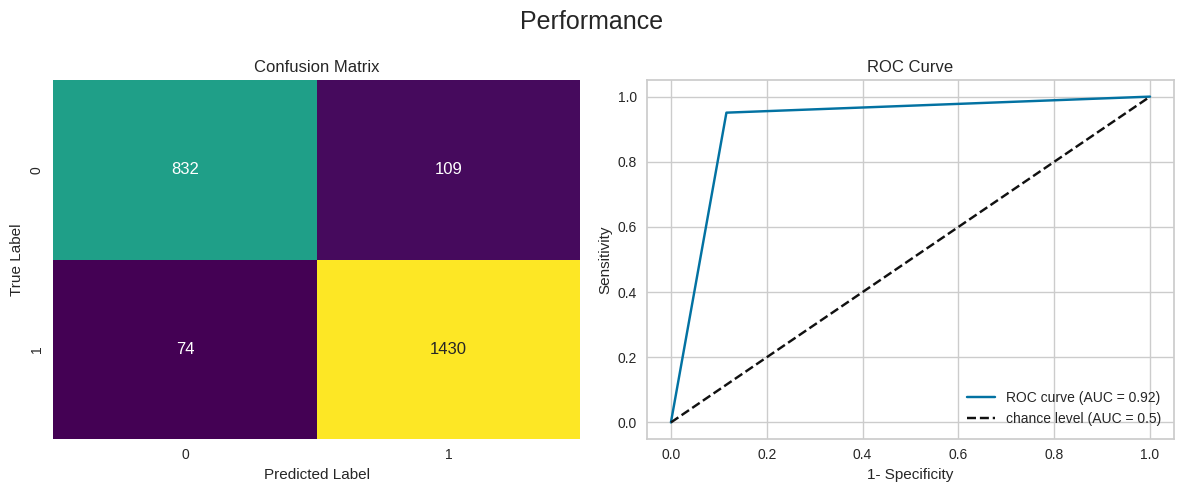

In [42]:
for clf in classifiers:
    print(f'Performance of {clf}:')
    print()
    y_pred = search[clf].best_estimator_.predict(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_score = round(auc(fpr, tpr), 2)
    temp = pl.DataFrame({"fpr": fpr, "tpr": tpr, "Model": f'{clf} AUC: {auc_score}'})
    roc_df = pl.concat([roc_df, temp])

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    temp = pl.DataFrame({"precision": precision, "recall": recall, "Model": f'{clf} AUC: {auc_score}'})
    prec_rec_df = pl.concat([prec_rec_df, temp])
    
    show_performance(y_test, y_pred)
    print()
    print('='*150)
    print()

#### With Abacus signature

##### Create the signatures

###### Get the bins

In [43]:
abacus_df_pre = (df
                 .lazy()
                 .filter((pl.col('proto')==6)|(pl.col('proto')==17))
                 .sort('sniff_timestamp')
                 .groupby(['src', 'srcport', 'proto', 'dst', 'dstport'], maintain_order=True)
                 .agg(Bytes=pl.col('len').sum().apply(lambda x: math.floor(math.log(x, 2))+1),
                      Packets=pl.count().apply(lambda x: math.floor(math.log(x, 2))+1),
                      IAT=pl.col('sniff_timestamp').diff().mean())
                 .fill_null(0)
                 .with_columns(pl.col('IAT').apply(lambda x: math.floor(math.log(x*1e6+1, 2))+1))
                 .groupby(['dst', 'dstport', 'proto'])
                 .agg(pl.col('Bytes'),
                      pl.col('Packets'),
                      pl.col('IAT'))).collect()

display(abacus_df_pre)

dst,dstport,proto,Bytes,Packets,IAT
str,i64,i64,list[i64],list[i64],list[i64]
"""131.137.177.10…",50816,6,[15],[8],[15]
"""45.131.99.171""",443,6,"[15, 14, … 13]","[6, 5, … 3]","[15, 17, … 20]"
"""74.126.15.37""",443,6,"[15, 15, … 10]","[9, 9, … 2]","[13, 14, … 15]"
"""74.126.5.108""",443,6,"[14, 13, 12]","[8, 7, 6]","[15, 12, 12]"
"""35.138.195.67""",443,6,"[13, 14, … 14]","[5, 6, … 4]","[18, 18, … 16]"
"""182.60.28.127""",55126,6,[20],[9],[14]
"""202.9.25.5""",52460,6,[8],[2],[1]
"""104.143.144.32…",53,17,"[7, 7, … 7]","[1, 1, … 1]","[1, 1, … 1]"
"""131.137.243.20…",39412,6,[20],[10],[13]


###### Encode the bins

In [44]:
bytes_max = abacus_df_pre.get_column('Bytes').apply(max).max()
packets_max = abacus_df_pre.get_column('Packets').apply(max).max()
iat_max = abacus_df_pre.get_column('IAT').apply(max).max()

def encode_bins(row: list[float],
                dim: int) -> list[float]:
    """This function encodes in the bin signature a given list of floats.

    Args:
        - row (list[float]): The starting list of values to encode.
        - dim (int): The dimention of the encodings.

    Returns:
        - array (list[float]): The encoded array.
    """
    n = len(row)
    array = np.zeros(dim)
    counter = Counter(row)
    for elem in counter:
        array[elem-1] = counter[elem]

    array /= n
    return list(array)

abacus_df = (abacus_df_pre
             .lazy()
             .with_columns(pl.col('Bytes').apply(lambda x: encode_bins(x, dim=bytes_max)),
                           pl.col('Packets').apply(lambda x: encode_bins(x, dim=packets_max)),
                           pl.col('IAT').apply(lambda x: encode_bins(x, dim=iat_max)))).collect()

display(abacus_df)

dst,dstport,proto,Bytes,Packets,IAT
str,i64,i64,list[f64],list[f64],list[f64]
"""131.137.177.10…",50816,6,"[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]"
"""45.131.99.171""",443,6,"[0.0, 0.0, … 0.0]","[0.0, 0.125, … 0.0]","[0.0, 0.0, … 0.0]"
"""74.126.15.37""",443,6,"[0.0, 0.0, … 0.0]","[0.142857, 0.142857, … 0.0]","[0.142857, 0.0, … 0.0]"
"""74.126.5.108""",443,6,"[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]"
"""35.138.195.67""",443,6,"[0.0, 0.0, … 0.0]","[0.0, 0.066667, … 0.0]","[0.0, 0.0, … 0.0]"
"""182.60.28.127""",55126,6,"[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]"
"""202.9.25.5""",52460,6,"[0.0, 0.0, … 0.0]","[0.0, 1.0, … 0.0]","[1.0, 0.0, … 0.0]"
"""104.143.144.32…",53,17,"[0.0, 0.0, … 0.0]","[1.0, 0.0, … 0.0]","[1.0, 0.0, … 0.0]"
"""131.137.243.20…",39412,6,"[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]"


##### Plotting the distributions

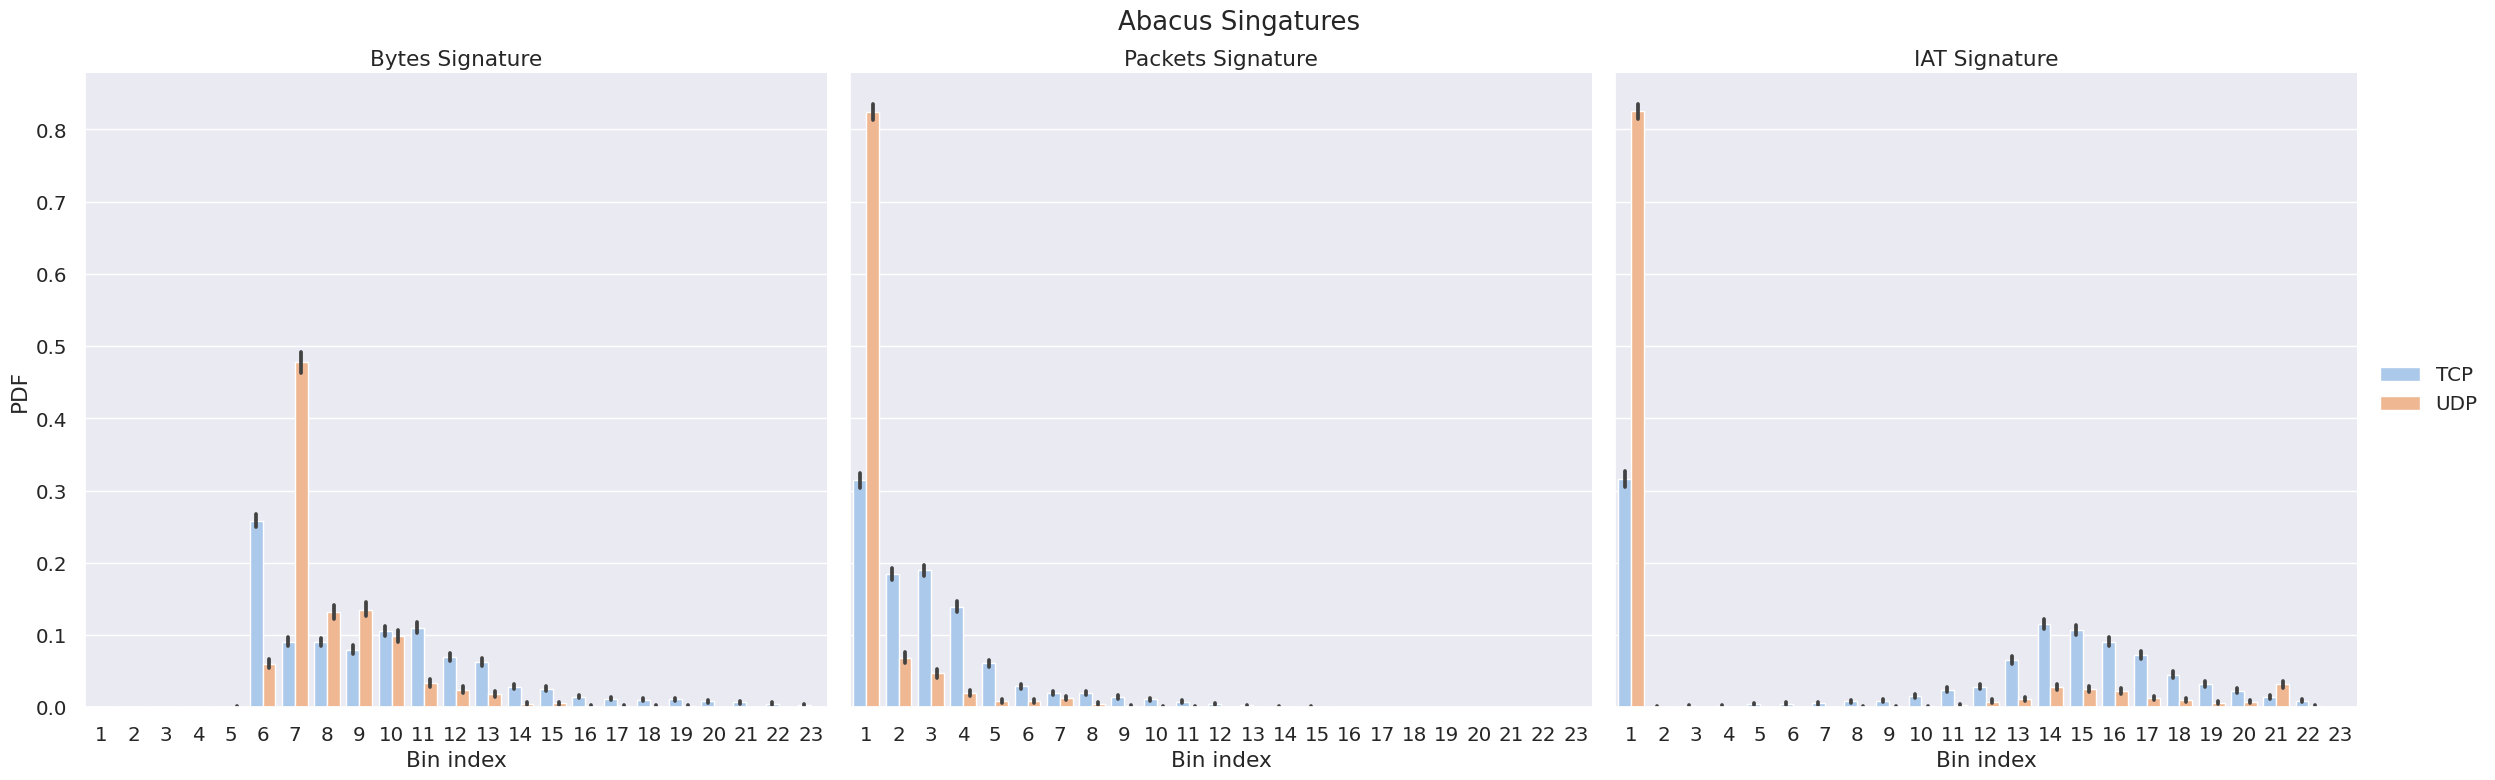

In [45]:
 abacus_df_shaped = (abacus_df
                     .lazy()
                     .with_columns(
                         proto=pl.when(pl.col("proto")
                                       .eq(pl.lit(6)))
                                       .then(pl.lit('TCP'))
                                       .otherwise(pl.lit('UDP')),
                         dst=pl.col('dst').apply(lambda ip: int(ipaddress.IPv4Address(ip))),
                         *[pl.col('Bytes').apply(lambda x, i=i: x[i-1]).alias(f'Bytes_{i}') for i in range(1, bytes_max+1)],
                         *[pl.col('Packets').apply(lambda x, i=i: x[i-1]).alias(f'Packets_{i}') for i in range(1, packets_max+1)],
                         *[pl.col('IAT').apply(lambda x, i=i: x[i-1]).alias(f'IAT_{i}') for i in range(1, iat_max+1)])
                     .drop('Bytes', 'Packets', 'IAT')).collect()

distr_plot = (abacus_df_shaped
             .lazy()
             .drop('dst', 'dstport')
             .melt(id_vars='proto', variable_name='type', value_name='frequency')
             .with_columns(bin=pl.col('type').apply(lambda x: int(x.split('_')[-1])),
                           type=pl.col('type').apply(lambda x: x.split('_')[0]))).collect()


sns.set(font_scale=1.3)
plot = sns.FacetGrid(distr_plot.to_pandas(),
                     col="type",
                     height=8,
                     aspect=1,
                     legend_out=True)
plot.map_dataframe(sns.barplot,
                   x="bin",
                   y='frequency',
                   hue='proto',
                   palette='pastel')
plot.set(xlabel='Bin index', ylabel='PDF')
plot.add_legend()
plot.fig.suptitle('Abacus Singatures')
plot.fig.subplots_adjust(top=0.9)
plot.set_titles("{col_name} Signature")
sns.despine()
plt.savefig("abacus_signatures.svg", format='svg', bbox_inches = "tight")
plt.show()

##### Getting the dataframe for the classification

In [46]:
abacus_signatures_df = abacus_df_shaped.with_columns(proto=pl.when(pl.col("proto").eq(pl.lit('TCP'))).then(pl.lit(1)).otherwise(pl.lit(0)))
display(abacus_signatures_df)

dst,dstport,proto,Bytes_1,Bytes_2,Bytes_3,Bytes_4,Bytes_5,Bytes_6,Bytes_7,Bytes_8,Bytes_9,Bytes_10,Bytes_11,Bytes_12,Bytes_13,Bytes_14,Bytes_15,Bytes_16,Bytes_17,Bytes_18,Bytes_19,Bytes_20,Bytes_21,Bytes_22,Bytes_23,Bytes_24,Bytes_25,Bytes_26,Packets_1,Packets_2,Packets_3,Packets_4,Packets_5,Packets_6,Packets_7,Packets_8,Packets_9,Packets_10,Packets_11,Packets_12,Packets_13,Packets_14,Packets_15,Packets_16,IAT_1,IAT_2,IAT_3,IAT_4,IAT_5,IAT_6,IAT_7,IAT_8,IAT_9,IAT_10,IAT_11,IAT_12,IAT_13,IAT_14,IAT_15,IAT_16,IAT_17,IAT_18,IAT_19,IAT_20,IAT_21,IAT_22,IAT_23
i64,i64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2206839050,50816,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
763585451,443,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.25,0.5,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.125,0.125,0.5,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.25,0.375,0.0,0.125,0.125,0.0,0.0,0.0
1249775397,443,1,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.142857,0.428571,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.142857,0.428571,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.142857,0.142857,0.0,0.0,0.428571,0.0,0.0,0.0,0.0,0.0
1249772908,443,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596296515,443,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.066667,0.266667,0.333333,0.2,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.533333,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.133333,0.2,0.4,0.066667,0.066667,0.0,0.0,0.0
3057392767,55126,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3389593861,52460,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1754239008,53,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2206856138,39412,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Correlation Matrix

/home/nihil/nbd_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nihil/nbd_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


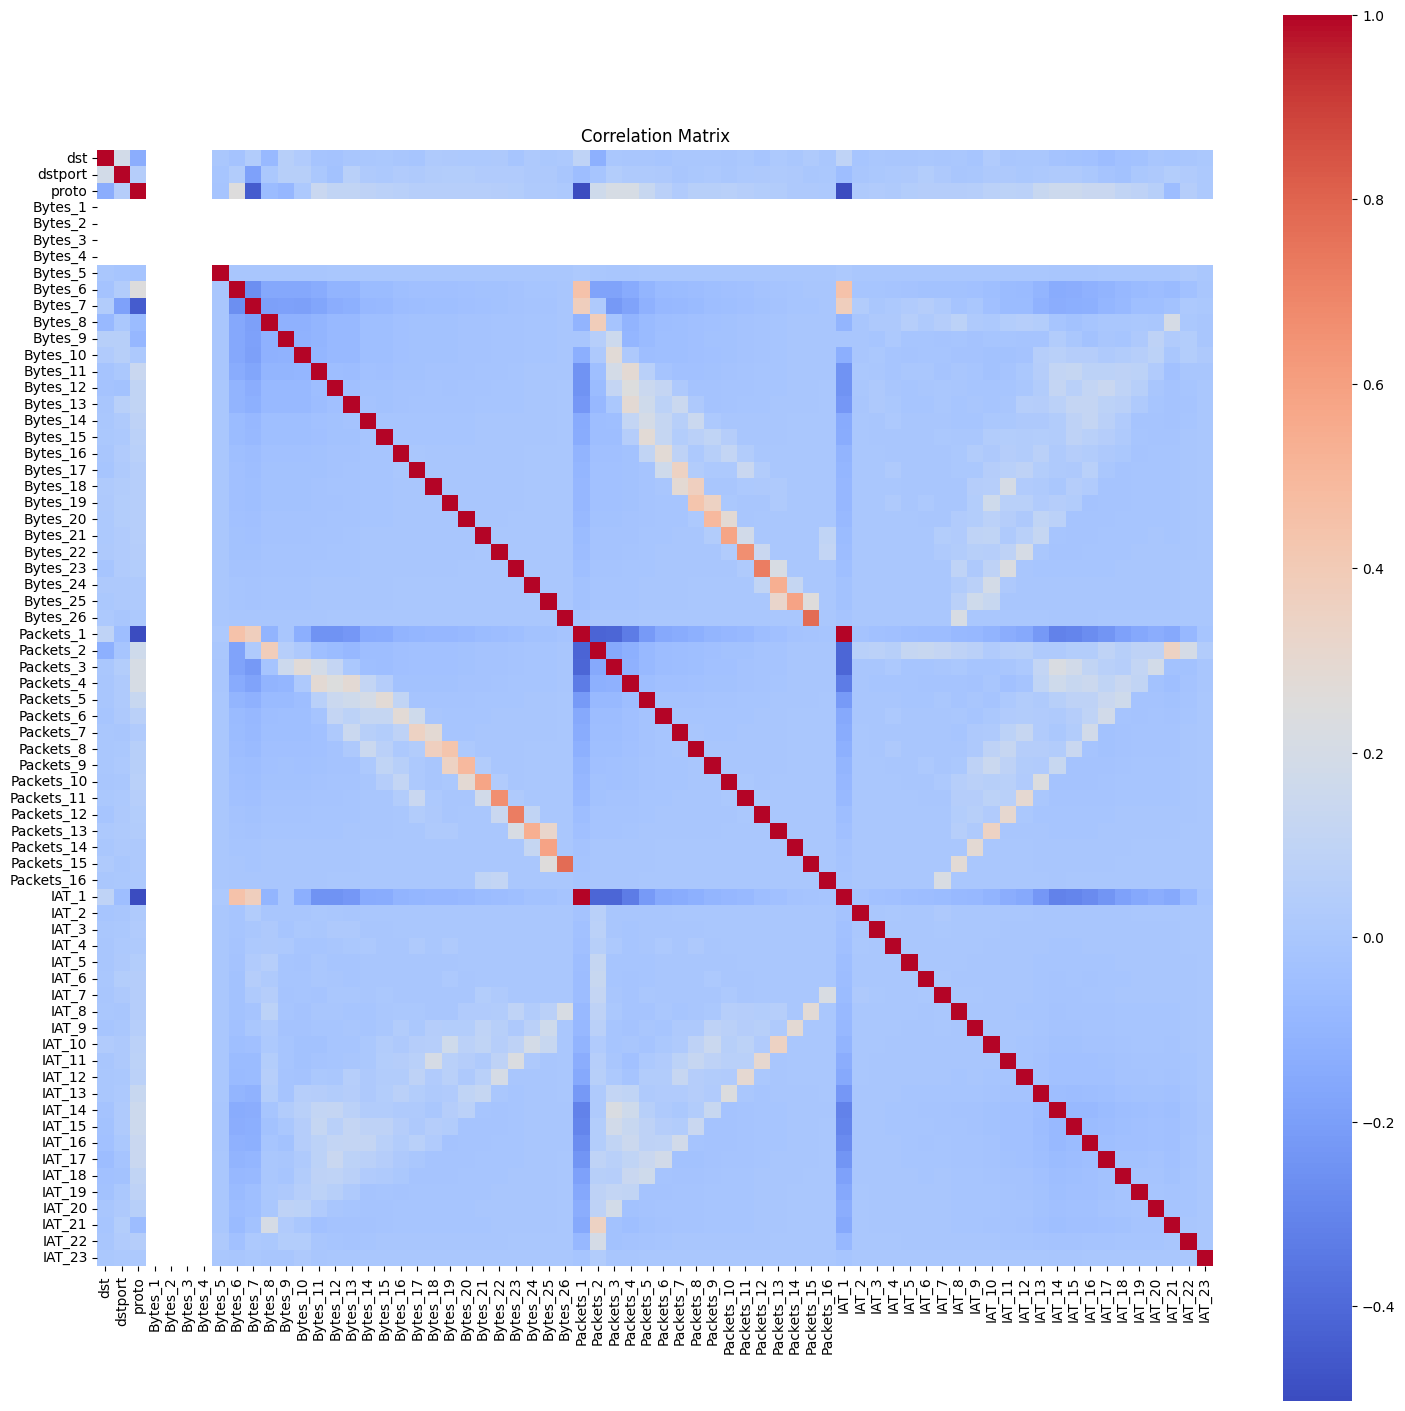

In [47]:
sns.reset_defaults()
plt.figure(figsize = (18,18))
plot = sns.heatmap(abacus_signatures_df.corr().to_pandas().set_index(pd.Series(abacus_signatures_df.columns)),
                   cmap='coolwarm',
                   square=True)
plot.set(title='Correlation Matrix')
plt.savefig("cm_abacus_signatures.svg", format='svg', bbox_inches = "tight")
plt.show()

##### Training and test set

In [48]:
train_df, test_df = train_test_split(abacus_signatures_df.to_pandas(), test_size=0.2, random_state=seed)

X_train = train_df.drop(['proto'], axis=1).to_numpy()
y_train = train_df['proto'].to_numpy()
X_test = test_df.drop(['proto'], axis=1).to_numpy()
y_test = test_df['proto'].to_numpy()

scaler = StandardScaler().fit(X_train)

##### Performing PCA

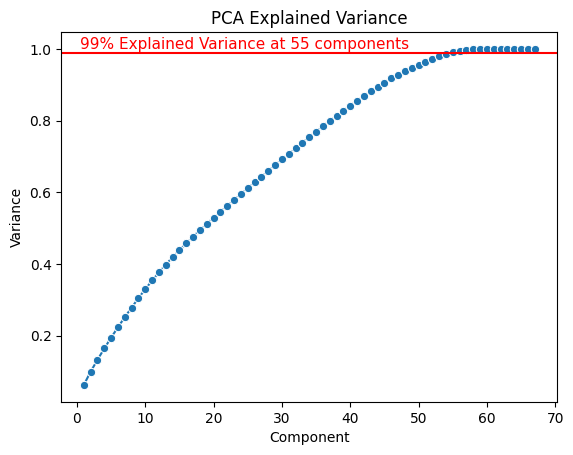

In [49]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

var = 0.99
pca = PCA().fit(X_train)

plot = sns.lineplot(x=range(1, pca.explained_variance_ratio_.shape[0]+1),
                    y=np.cumsum(pca.explained_variance_ratio_),
                    marker='o')
plot.set(title='PCA Explained Variance',
         xlabel='Component',
         ylabel='Variance')

pca_var = np.cumsum(pca.explained_variance_ratio_)
n_components = len(pca_var[pca_var<var])+1

plt.axhline(y=var, color='red', linestyle='-',linewidth=1.5)
plt.text(0.5, var+0.009, f'{int(var*100)}% Explained Variance at {n_components} components', color = 'red', fontsize=11)
plt.savefig("pca_abacus_signatures.svg", format='svg', bbox_inches = "tight")
plt.show()

pca = PCA(var).fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [50]:
X_train = train_df.drop(['proto'], axis=1).to_numpy()
y_train = train_df['proto'].to_numpy()
X_test = test_df.drop(['proto'], axis=1).to_numpy()
y_test = test_df['proto'].to_numpy()

abacus_classifiers = {
    'MultinomialNB': MultinomialNB(),
    'SVC': SVC(random_state=seed, max_iter=int(1e6)),
    'XGBClassifier': XGBClassifier(random_state=seed, objective='binary:logistic', n_jobs=n_jobs)
}

In [51]:
abacus_search = {}
for clf in tqdm(abacus_classifiers):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    if clf == 'MultinomialNB':
        pipeline = Pipeline([('scaler', StandardScaler()),
                             ('pca', PCA(var)),
                             ('normalizer', MinMaxScaler()),
                             ('clf', abacus_classifiers[clf])])
    else:
        pipeline = Pipeline([('scaler', StandardScaler()),
                             ('pca', PCA(var)),
                             ('clf', abacus_classifiers[clf])])
        
    random_search = RandomizedSearchCV(pipeline, param_distr[clf], cv=kf, random_state=seed, n_jobs=n_jobs, n_iter=n_iter)
    abacus_search[clf] = random_search.fit(X_train, y_train)


 33%|██████████████████████████████████████████████████████████▎                                                                                                                    | 1/3 [00:03<00:06,  3.44s/it]/home/nihil/nbd_project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nihil/nbd_project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nihil/nbd_project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nihil/nbd_project/.venv/lib/python3.11/site-packages/sklearn/svm/_base

Performance of MultinomialNB:

Classification report:
              precision    recall  f1-score   support

           0       0.63      0.83      0.72       945
           1       0.87      0.69      0.77      1500

    accuracy                           0.75      2445
   macro avg       0.75      0.76      0.74      2445
weighted avg       0.78      0.75      0.75      2445



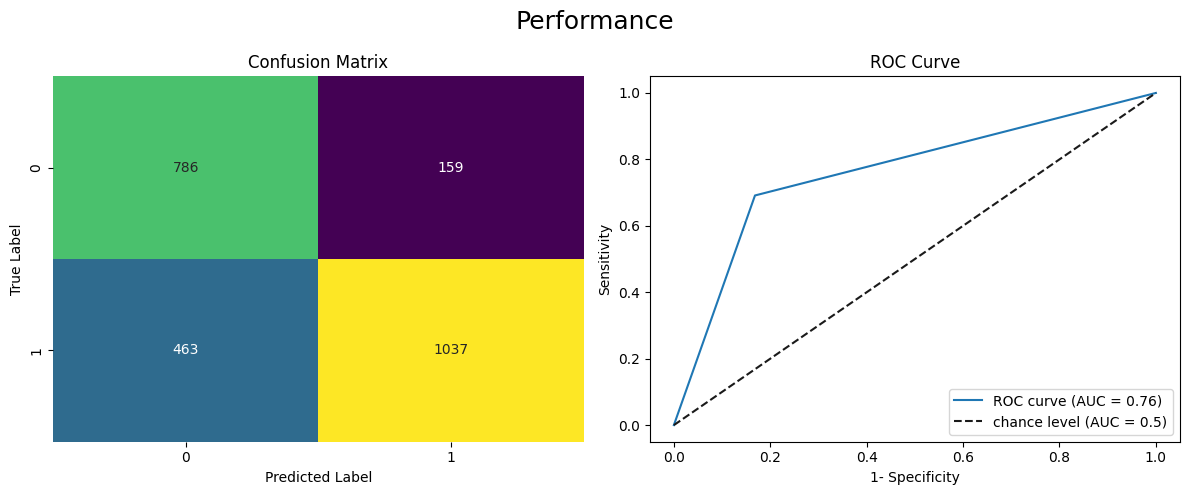



Performance of SVC:

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       945
           1       0.90      0.94      0.92      1500

    accuracy                           0.90      2445
   macro avg       0.89      0.88      0.89      2445
weighted avg       0.90      0.90      0.89      2445



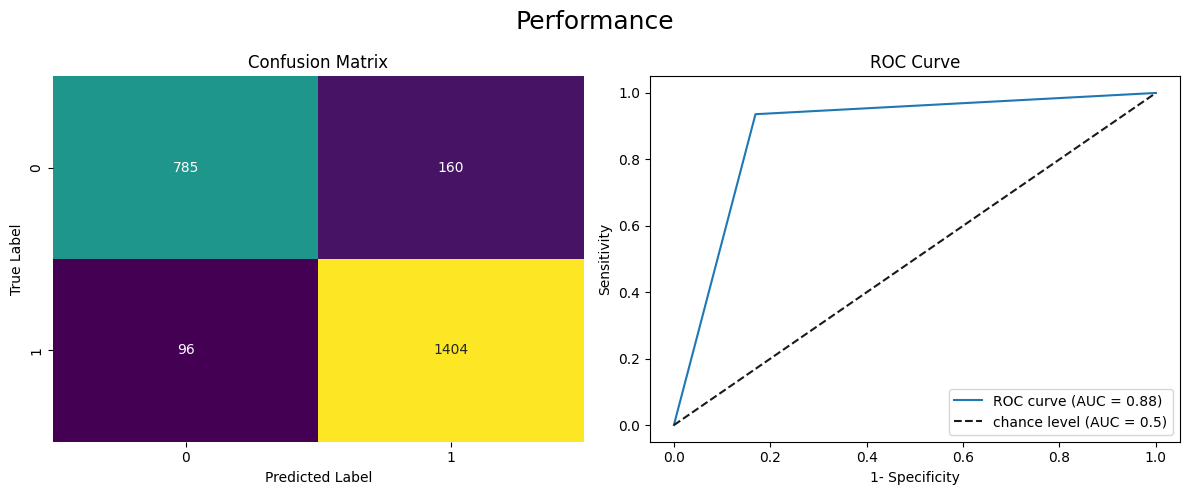



Performance of XGBClassifier:

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       945
           1       0.87      0.96      0.91      1500

    accuracy                           0.89      2445
   macro avg       0.90      0.87      0.88      2445
weighted avg       0.89      0.89      0.89      2445



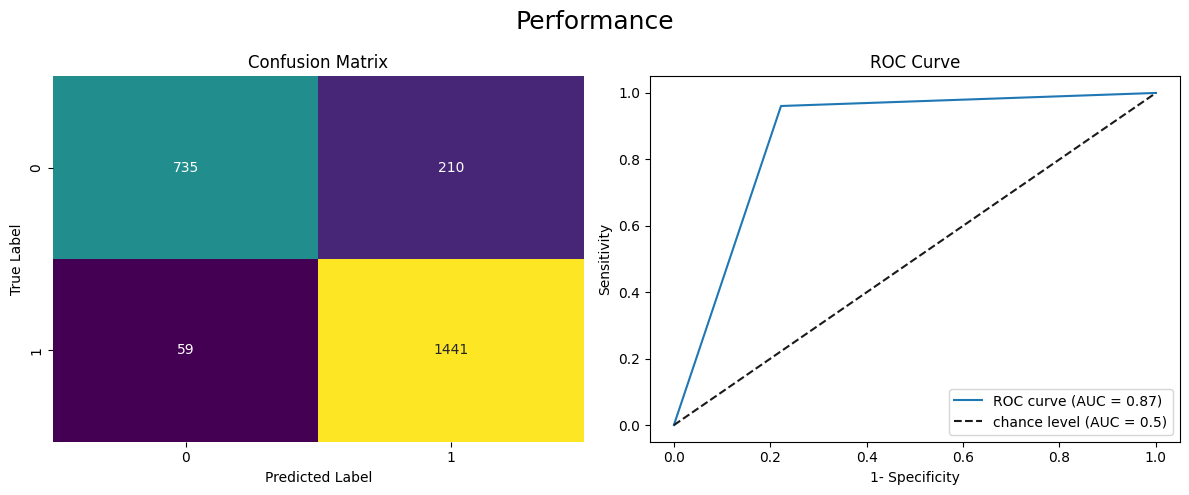

In [52]:
for clf in abacus_classifiers:
    print(f'Performance of {clf}:')
    print()
    y_pred = abacus_search[clf].best_estimator_.predict(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_score = round(auc(fpr, tpr), 2)
    temp = pl.DataFrame({"fpr": fpr, "tpr": tpr, "Model": f'abacus_{clf} AUC: {auc_score}'})
    roc_df = pl.concat([roc_df, temp])

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    temp = pl.DataFrame({"precision": precision, "recall": recall, "Model": f'abacus_{clf} AUC: {auc_score}'})
    prec_rec_df = pl.concat([prec_rec_df, temp])
    
    show_performance(y_test, y_pred)
    print()
    print('='*150)
    print()

### Results

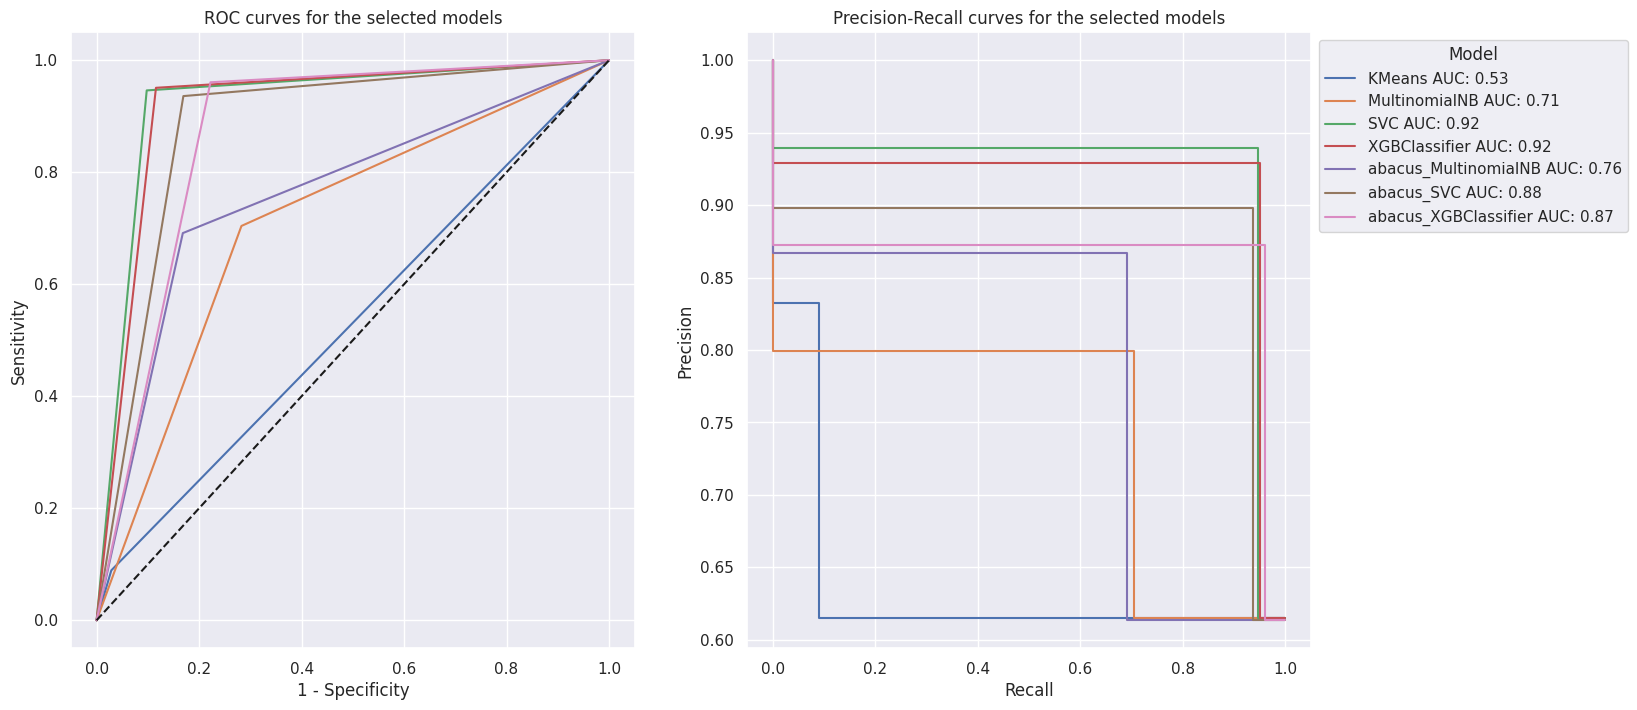

In [54]:
sns.set()
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.lineplot(data=roc_df, x="fpr", y="tpr", hue="Model", ax=ax[0], legend=False)
ax[0].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax[0].set_ylabel("Sensitivity")
ax[0].set_xlabel("1 - Specificity")
ax[0].set_title("ROC curves for the selected models")
sns.lineplot(data=prec_rec_df, x="recall", y="precision", hue="Model", drawstyle="steps-pre", ax=ax[1])
ax[1].set_ylabel("Precision")
ax[1].set_xlabel("Recall")
ax[1].set_title("Precision-Recall curves for the selected models")
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
plt.savefig("ml_results.svg", format='svg', bbox_inches = "tight")
plt.show()